#**0. Overview**

https://dacon.io/competitions/official/235670/overview/description

##**Import Library**

In [ ]:
!pip install koreanize-matplotlib
!pip install konlpy

In [ ]:
# 필요한 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import string
import spacy
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Import Data**

In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/test_x.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/sample_submission.csv')

In [ ]:
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [ ]:
test.head()

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...


#**1. EDA**

### 1. 불용어 처리

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

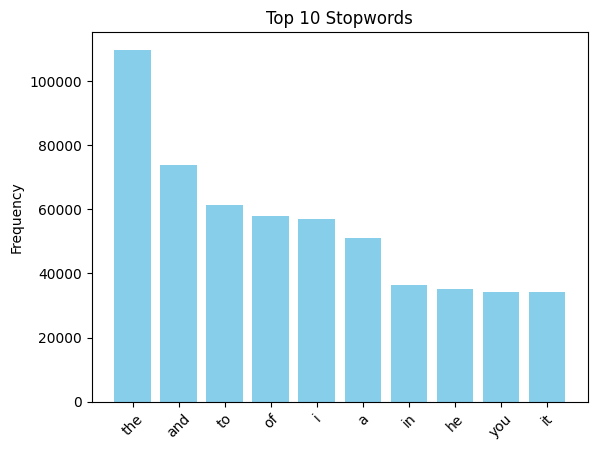

In [ ]:
#stopword 분포

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import defaultdict

def stopword_plot(texts):
    stop = set(stopwords.words('english'))

    corpus = []
    for sentence in texts:
        tokens = word_tokenize(sentence.lower())  # 소문자화
        # 알파벳만 필터링 (기호, 숫자 제외)
        tokens = [word for word in tokens if word.isalpha()]
        corpus += tokens

    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    # 상위 10개 stopwords 추출
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
    x, y = zip(*top)

    # 그래프 출력
    plt.bar(x, y, color='skyblue')
    plt.title("Top 10 Stopwords")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

stopword_plot(train['text'])

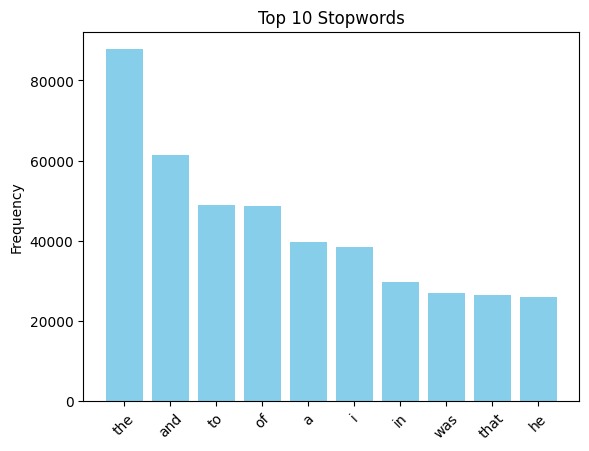

In [ ]:
# test 셋도 확인하기

stopword_plot(test['text'])

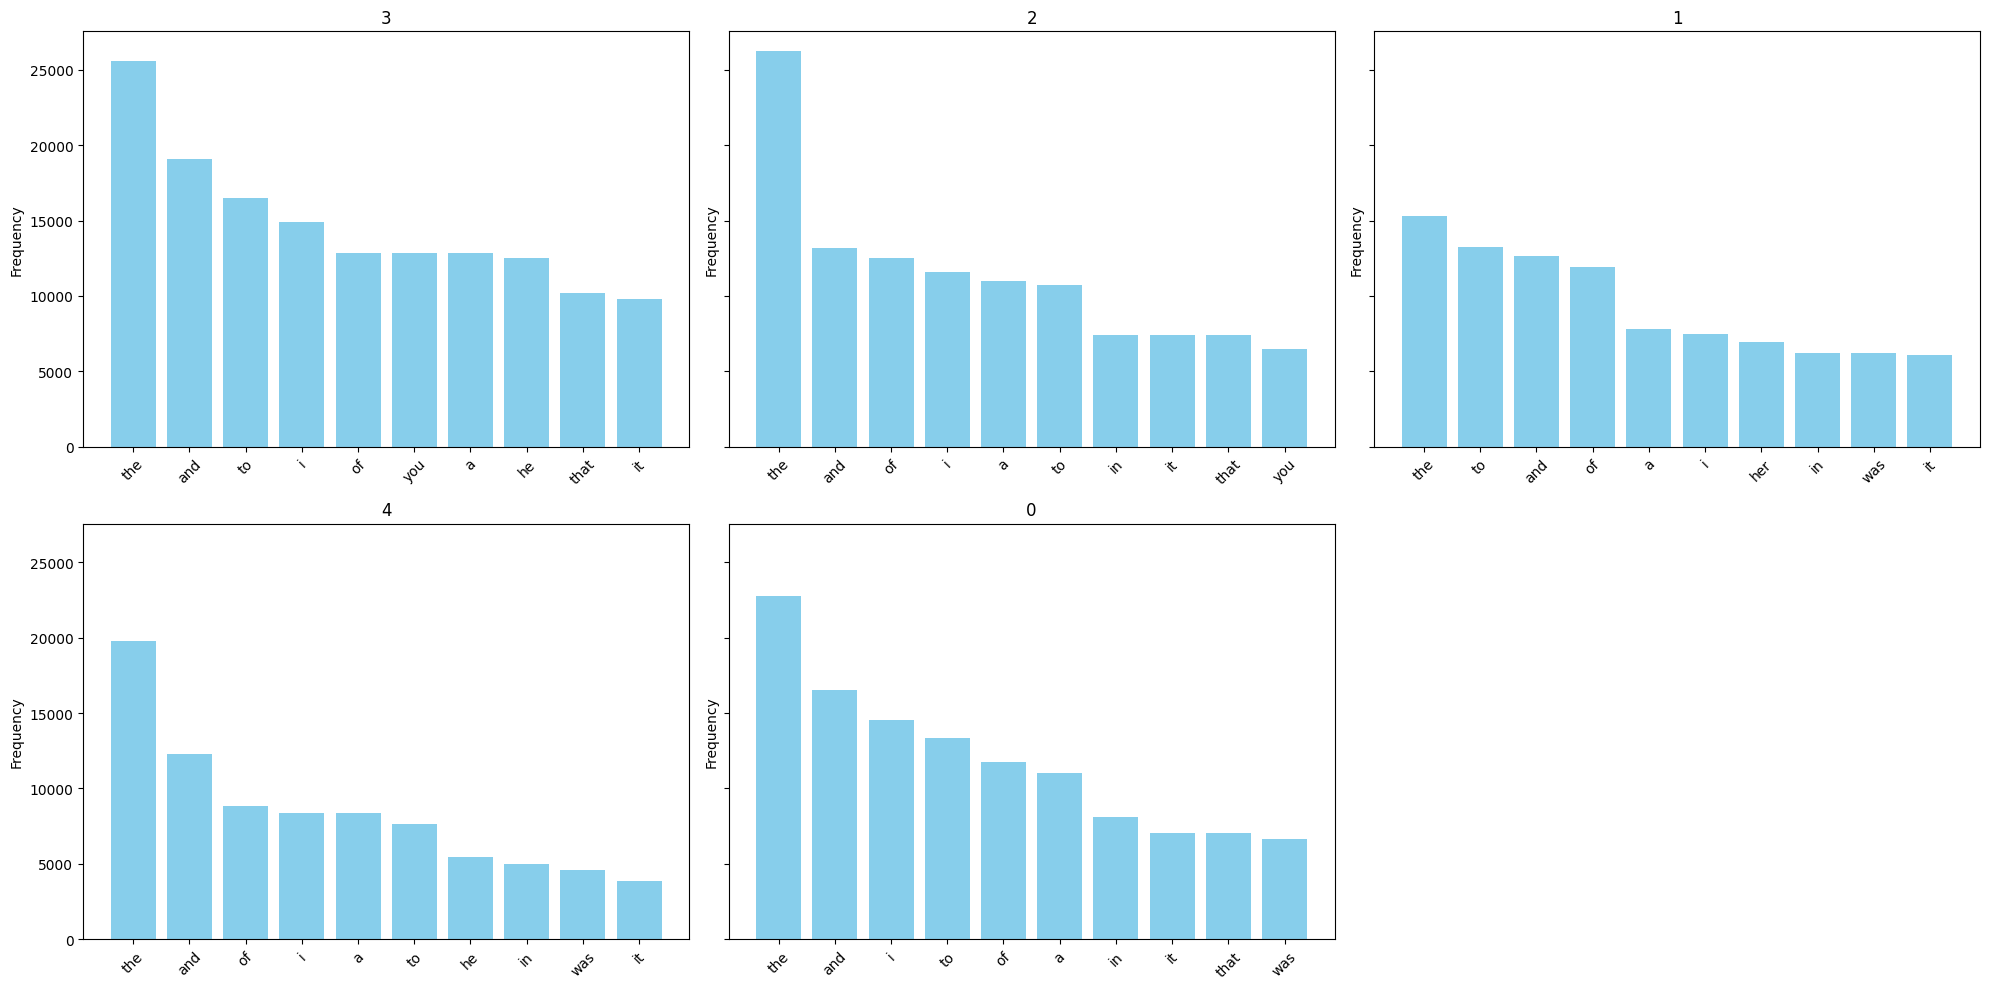

In [ ]:
# 작가별 불용어 분포

import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

def stopword_count(texts, stop_words):
    corpus = []
    for sentence in texts:
        tokens = word_tokenize(sentence.lower())  # 소문자화 + 토큰화
        tokens = [word for word in tokens if word.isalpha()]
        corpus += tokens

    dic = defaultdict(int)
    for word in corpus:
        if word in stop_words and word.isalpha():  # 불용어 필터링 + 알파벳만
            dic[word] += 1

    # 상위 10개 stopwords 추출
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
    x, y = zip(*top)

    return x, y

stop_words = set(stopwords.words('english'))
authors = train['author'].unique()
n_authors = len(authors)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)

for i, author in enumerate(authors):
    texts = train[train['author'] == author]['text']
    x, y = stopword_count(texts, stop_words)
    axes.flat[i].bar(x, y, color='skyblue')
    axes.flat[i].set_title(author)
    axes.flat[i].set_ylabel('Frequency')
    axes.flat[i].set_xticks(x)
    axes.flat[i].tick_params(axis='x', rotation=45)

if n_authors < 6:
    for j in range(n_authors, 6):
        fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

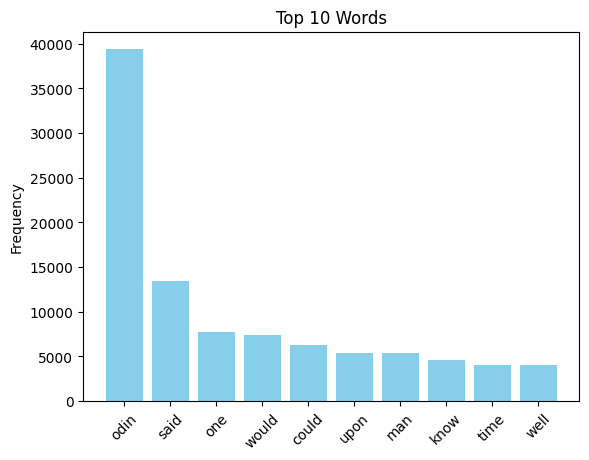

In [ ]:
# corpus 분포 확인

from collections import Counter

def corpus_plot(texts):
  stop= set(stopwords.words('english'))
  corpus = []
  for sentence in texts:
      tokens = word_tokenize(sentence.lower())  # 소문자화 + 토큰화
      tokens = [word for word in tokens if word.isalpha()]
      corpus.extend(tokens)

  word_counts = Counter(corpus)
  filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}
  top_10_words = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)[:10]
  x, y = zip(*top_10_words)

  plt.bar(x, y, color='skyblue')
  plt.title("Top 10 Words")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45)
  plt.show()

corpus_plot(train['text'])

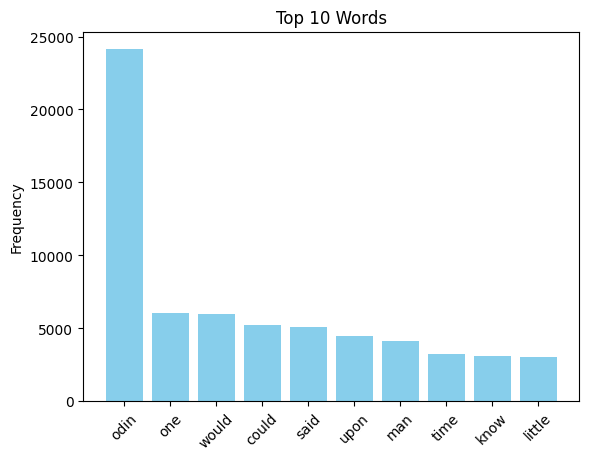

In [ ]:
# corpus test 버전

corpus_plot(test['text'])

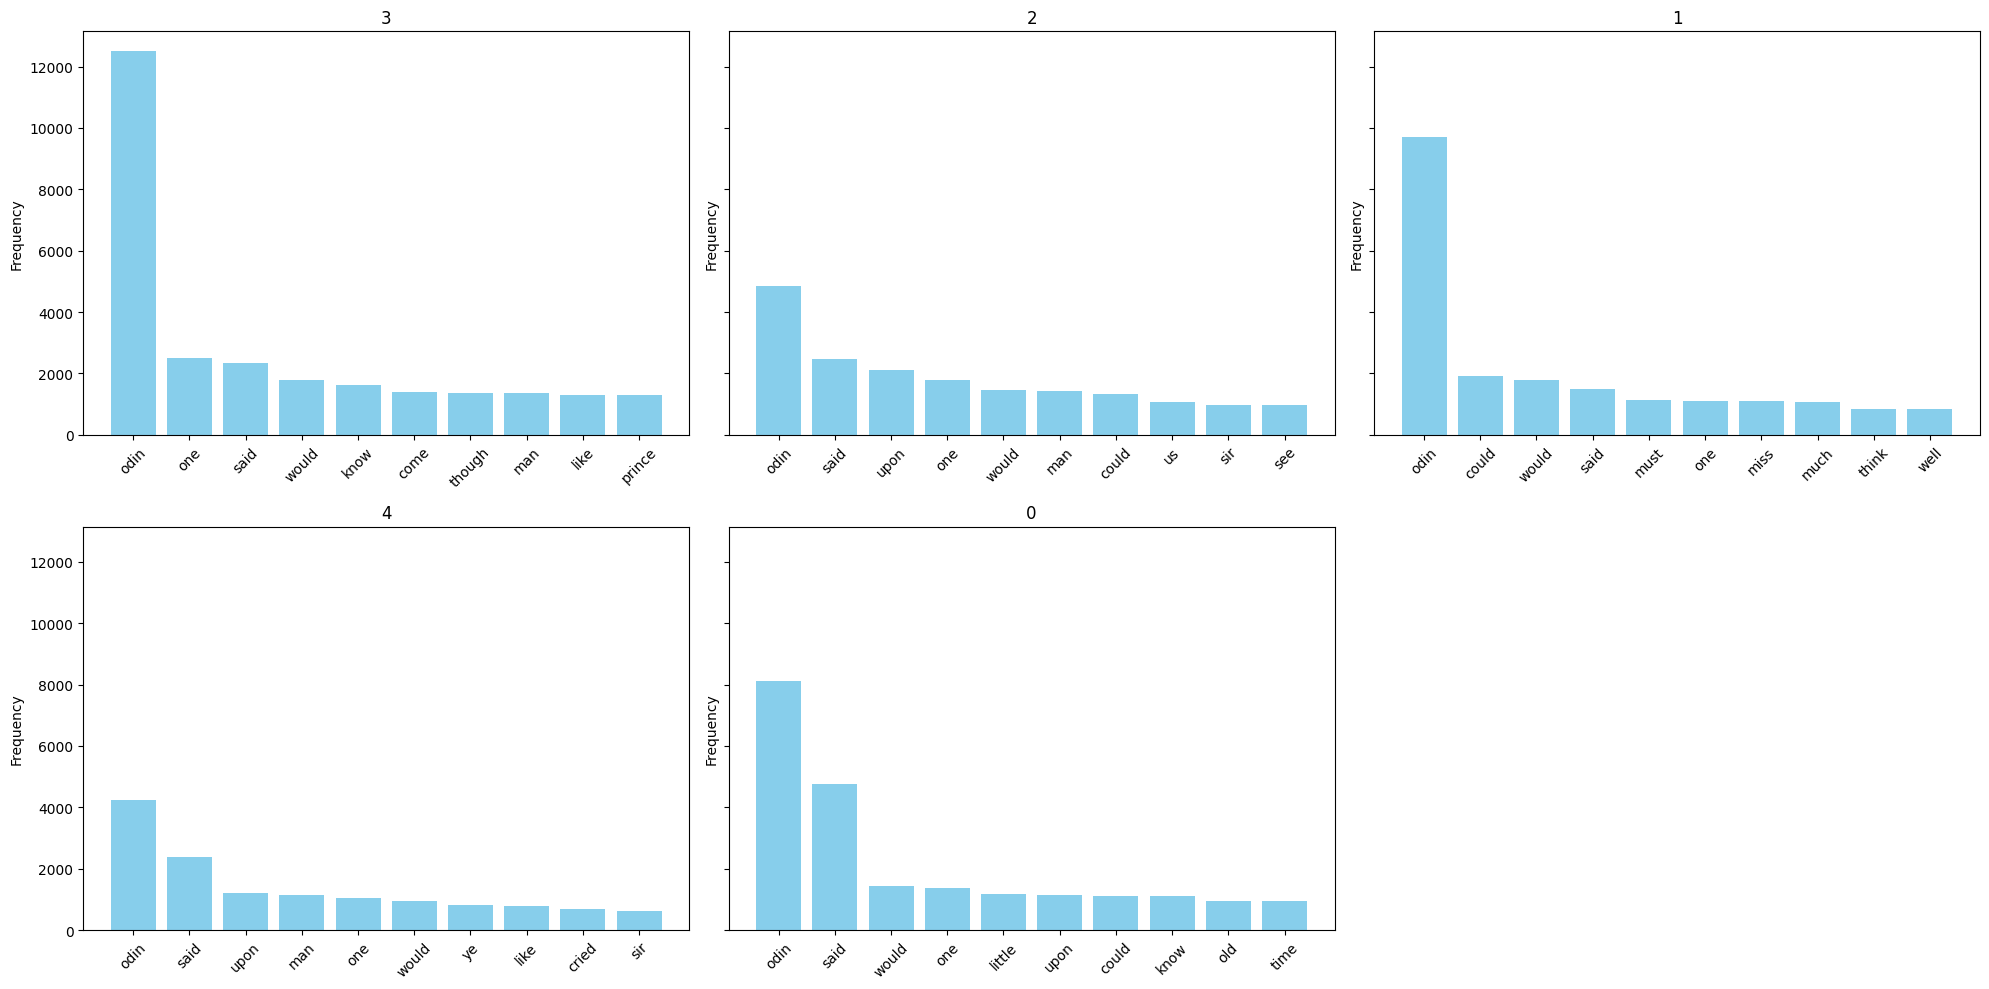

In [ ]:
# 작가별 corpus 분

def corpus_count(texts):
  stop= set(stopwords.words('english'))
  corpus = []
  for sentence in texts:
      tokens = word_tokenize(sentence.lower())  # 소문자화 + 토큰화
      tokens = [word for word in tokens if word.isalpha() and word not in stop]  # 불용어 + 알파벳만
      corpus.extend(tokens)

  word_counts = Counter(corpus)
  top_10_words = word_counts.most_common(10)
  x, y = zip(*top_10_words)

  return x, y

authors = train['author'].unique()
n_authors = len(authors)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)

for i, author in enumerate(authors):
    texts = train[train['author'] == author]['text']
    x, y = corpus_count(texts)
    axes.flat[i].bar(x, y, color='skyblue')
    axes.flat[i].set_title(author)
    axes.flat[i].set_ylabel('Frequency')
    axes.flat[i].set_xticks(x)
    axes.flat[i].tick_params(axis='x', rotation=45)

if n_authors < 6:
    for j in range(n_authors, 6):
        fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


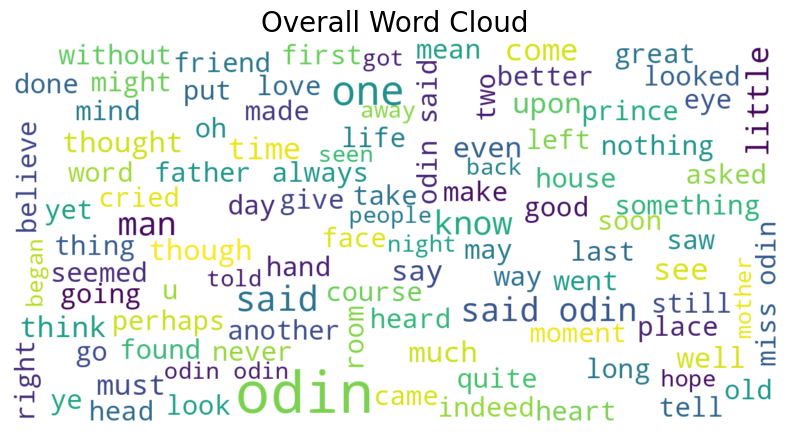

In [ ]:
# wordcloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# 전체 텍스트 합치기
text_data = ' '.join(train['text'].tolist())

# 토큰화, 소문자화, 불용어 제거, 알파벳 필터링
stop_words = set(stopwords.words('english'))
tokens = word_tokenize(text_data.lower())
filtered_words = [word for word in tokens if word.isalpha() and word not in stop_words]
final_text = ' '.join(filtered_words)

# 워드클라우드 생성
wordcloud = WordCloud(stopwords=set(STOPWORDS), max_words=100, max_font_size=30, scale=3, random_state=1, background_color='white').generate(final_text)

# 시각화
plt.figure(figsize=(10 , 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Overall Word Cloud", fontsize=20)
plt.show()

### 2. 사람 이름

어떤 고유명사가 많은지?

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

from collections import Counter

In [ ]:
doc=nlp(train['text'][2])

[(x.text,x.label_) for x in doc.ents]

[('one day', 'DATE'),
 ('Jane', 'PERSON'),
 ('Jane', 'PERSON'),
 ('odin', 'PERSON')]

In [ ]:
def get_ner(text):
  doc = nlp(text)
  return [x.label_ for x in doc.ents]

In [ ]:
def count_labels(texts):
  all_labels = []

  for text in texts:
    all_labels.extend(get_ner(text))

  label_counts = Counter(all_labels)
  ner_df = pd.DataFrame(label_counts.items(), columns=['label', 'count']).sort_values(by='count', ascending=False)
  return ner_df

In [ ]:
train_0 = train[train['author']==0]
train_1 = train[train['author']==1]
train_2 = train[train['author']==2]
train_3 = train[train['author']==3]
train_4 = train[train['author']==4]

In [ ]:
train_0

,index,text,author
8,8,"'You were not here last Sunday night,' he said.",0
12,12,"I had scant luggage to take with me to London,...",0
19,19,"‘Why, the fact is,’ returned odin, ‘Mr. odin h...",0
20,20,"Dora was delighted with the little presents, a...",0
23,23,"The kind tone of this answer, the sweet voice,...",0
...,...,...,...
54869,54869,"'You are afraid, Brittles,' said Mr. odin.",0
54870,54870,“Don't fear me. I will be true to the death.”,0
54872,54872,"‘And the premium, sir,’ I returned, ‘is a thou...",0
54873,54873,"He looked back over his shoulder, and beckoned...",0


In [ ]:
ner_df_0 = count_labels(train_0['text'].tolist())
ner_df_1 = count_labels(train_1['text'].tolist())
ner_df_2 = count_labels(train_2['text'].tolist())
ner_df_3 = count_labels(train_3['text'].tolist())
ner_df_4 = count_labels(train_4['text'].tolist())

In [ ]:
ner_df_0

,label,count
3,PERSON,7563
4,CARDINAL,1754
5,ORG,1584
0,DATE,1183
1,TIME,1040
2,GPE,765
9,ORDINAL,605
7,NORP,420
8,WORK_OF_ART,142
10,QUANTITY,127


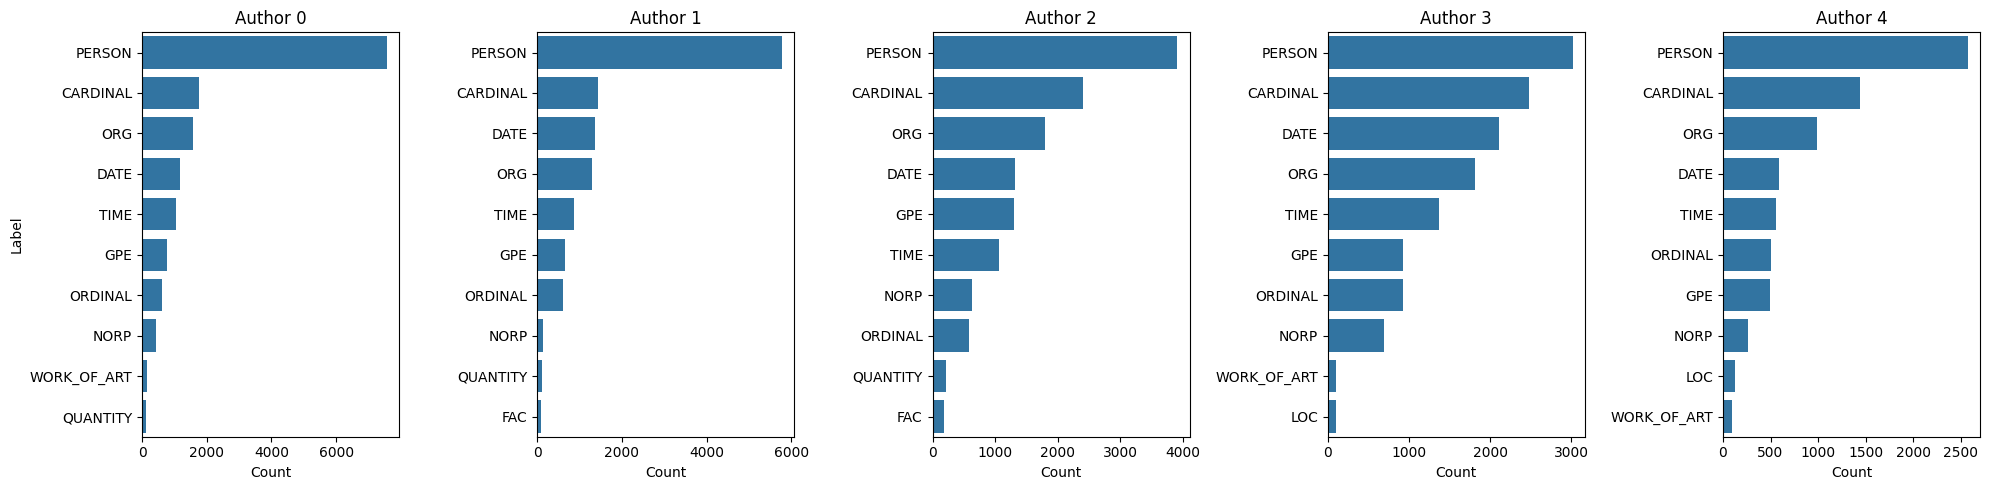

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

dfs = [ner_df_0, ner_df_1, ner_df_2, ner_df_3, ner_df_4]

for i, df in enumerate(dfs):
  top = df.head(10)
  sns.barplot(data=top, x='count', y='label', ax=axes[i])
  axes[i].set_title(f"Author {i}")
  axes[i].set_xlabel("Count")
  axes[i].set_ylabel("Label" if i == 0 else "")

plt.tight_layout()
plt.show()

어떤 사람 이름이 많은지?

In [ ]:
def get_person(text):
  doc = nlp(text)
  return [x.text for x in doc.ents if x.label_ == 'PERSON']

In [ ]:
def count_people(texts):
  all_people = []

  for text in texts:
    all_people.extend(get_person(text))

  person_counts = Counter(all_people)
  person_df = pd.DataFrame(person_counts.items(), columns=['person', 'count']).sort_values(by='count', ascending=False)
  return person_df

In [ ]:
person_df_0 = count_people(train_0['text'].tolist())
person_df_1 = count_people(train_1['text'].tolist())
person_df_2 = count_people(train_2['text'].tolist())
person_df_3 = count_people(train_3['text'].tolist())
person_df_4 = count_people(train_4['text'].tolist())

In [ ]:
person_df_0.head()

,person,count
0,odin,2540
5,Joe,481
2,Miss,381
1,Dora,311
4,Pip,136


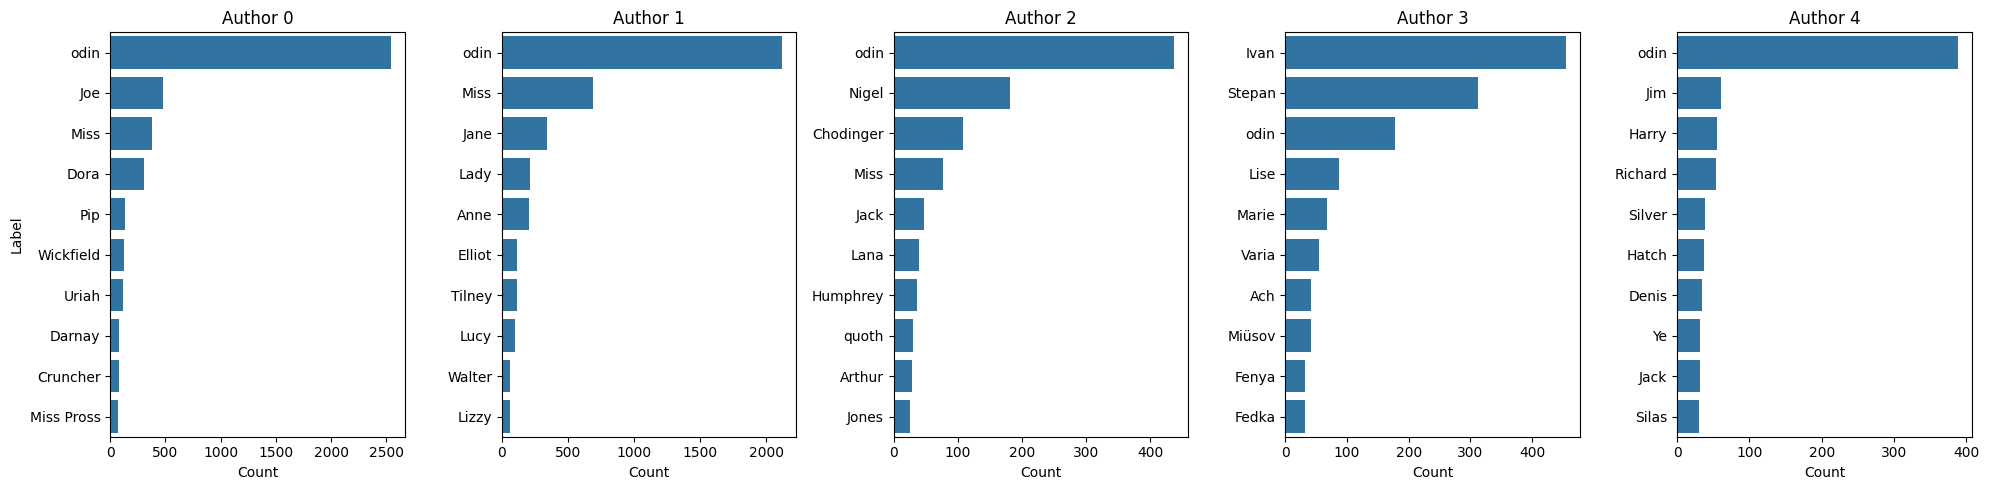

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

dfs = [person_df_0, person_df_1, person_df_2, person_df_3, person_df_4]

for i, df in enumerate(dfs):
  top = df.head(10)
  sns.barplot(data=top, x='count', y='person', ax=axes[i])
  axes[i].set_title(f"Author {i}")
  axes[i].set_xlabel("Count")
  axes[i].set_ylabel("Label" if i == 0 else "")

plt.tight_layout()
plt.show()

In [ ]:
train_wo_odin = train[~train['text'].str.contains('odin', case=False)]

train_wo_odin_0 = train_wo_odin[train_wo_odin['author']==0]
train_wo_odin_1 = train_wo_odin[train_wo_odin['author']==1]
train_wo_odin_2 = train_wo_odin[train_wo_odin['author']==2]
train_wo_odin_3 = train_wo_odin[train_wo_odin['author']==3]
train_wo_odin_4 = train_wo_odin[train_wo_odin['author']==4]

In [ ]:
wo_odin_df_0 = count_labels(train_wo_odin_0['text'].tolist())
wo_odin_df_1 = count_labels(train_wo_odin_1['text'].tolist())
wo_odin_df_2 = count_labels(train_wo_odin_2['text'].tolist())
wo_odin_df_3 = count_labels(train_wo_odin_3['text'].tolist())
wo_odin_df_4 = count_labels(train_wo_odin_4['text'].tolist())

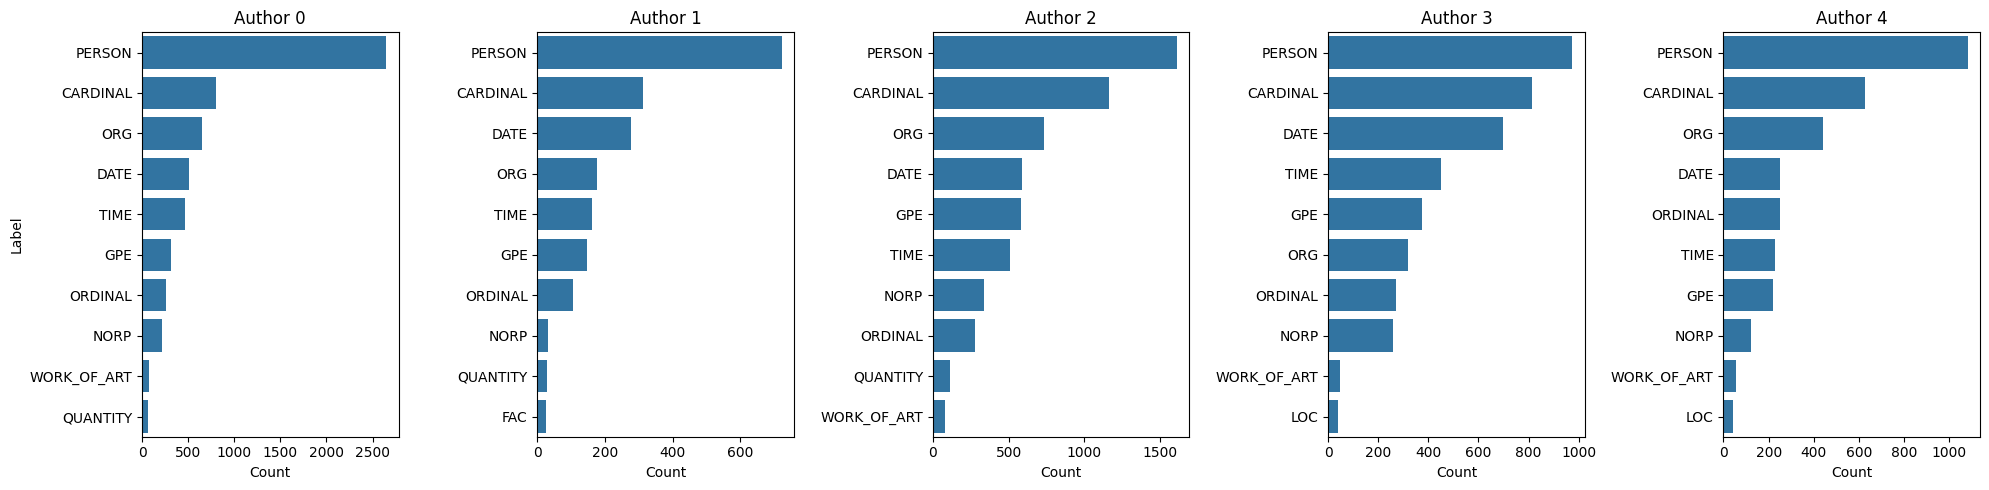

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

dfs = [wo_odin_df_0, wo_odin_df_1, wo_odin_df_2, wo_odin_df_3, wo_odin_df_4]

for i, df in enumerate(dfs):
  top = df.head(10)
  sns.barplot(data=top, x='count', y='label', ax=axes[i])
  axes[i].set_title(f"Author {i}")
  axes[i].set_xlabel("Count")
  axes[i].set_ylabel("Label" if i == 0 else "")

plt.tight_layout()
plt.show()

cardinal

In [ ]:
def get_cardinal(text):
  doc = nlp(text)
  return [x.text for x in doc.ents if x.label_ == 'CARDINAL']

In [ ]:
def count_cardinal(texts):
  all_cardinals = []

  for text in texts:
    all_cardinals.extend(get_cardinal(text))

  cardinal_counts = Counter(all_cardinals)
  cardinal_df = pd.DataFrame(cardinal_counts.items(), columns=['cardinal', 'count']).sort_values(by='count', ascending=False)
  return cardinal_df

In [ ]:
cardinal_df_0 = count_cardinal(train_0['text'].tolist())
cardinal_df_1 = count_cardinal(train_1['text'].tolist())
cardinal_df_2 = count_cardinal(train_2['text'].tolist())
cardinal_df_3 = count_cardinal(train_3['text'].tolist())
cardinal_df_4 = count_cardinal(train_4['text'].tolist())

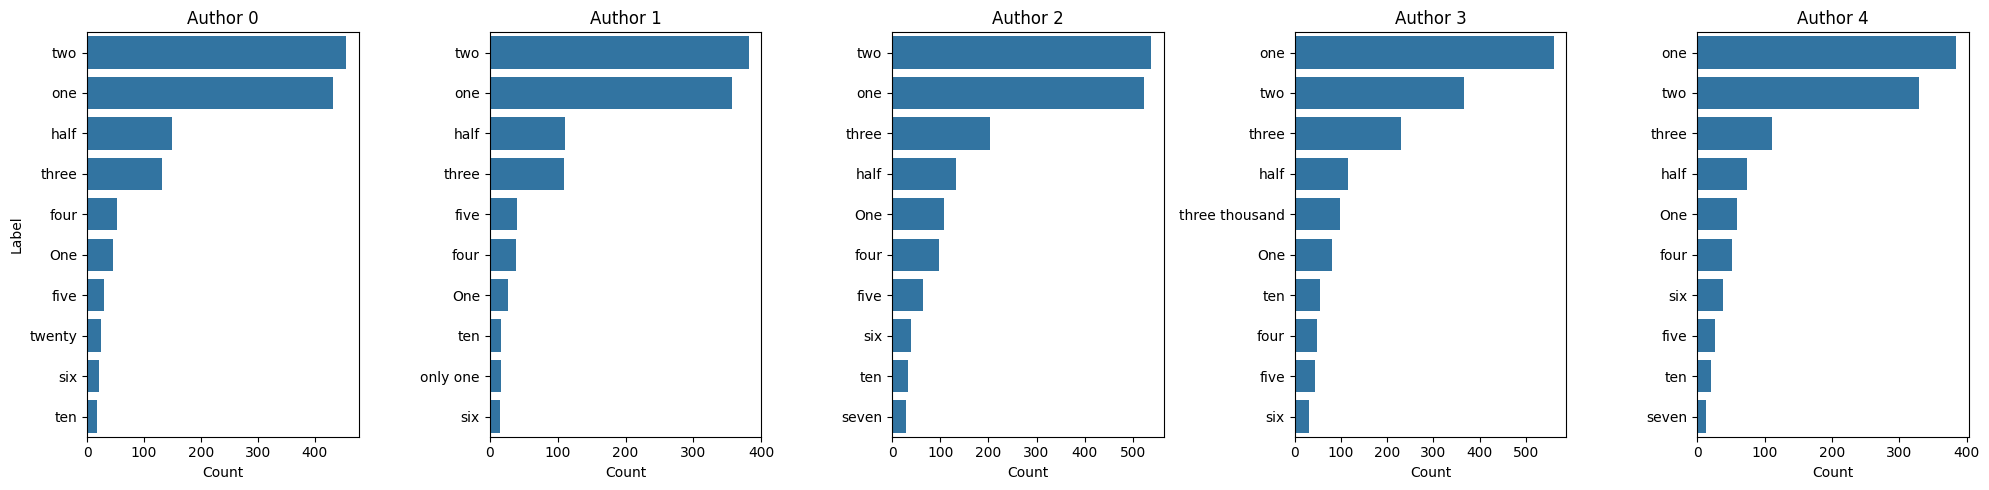

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

dfs = [cardinal_df_0, cardinal_df_1, cardinal_df_2, cardinal_df_3, cardinal_df_4]

for i, df in enumerate(dfs):
  top = df.head(10)
  sns.barplot(data=top, x='count', y='cardinal', ax=axes[i])
  axes[i].set_title(f"Author {i}")
  axes[i].set_xlabel("Count")
  axes[i].set_ylabel("Label" if i == 0 else "")

plt.tight_layout()
plt.show()

### 3. 감성분석

In [ ]:
# 첫 번째 데이터에 대해서 해보자
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(X_train['text'][0])
print(senti_scores)

{'neg': 0.079, 'neu': 0.837, 'pos': 0.084, 'compound': 0.3064}


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

senti_analyzer = SentimentIntensityAnalyzer()

def plot_vader_polarity_histogram(text_series):
    def get_compound_score(text):
        return senti_analyzer.polarity_scores(text)['compound']

    compound_scores = text_series.apply(get_compound_score)

    # 시각화
    plt.figure(figsize = (8, 4))
    plt.hist(compound_scores, bins=20)
    plt.title('VADER Compound Score Distribution')
    plt.ylabel("빈도")
    plt.grid(True)
    plt.show()

    return compound_scores

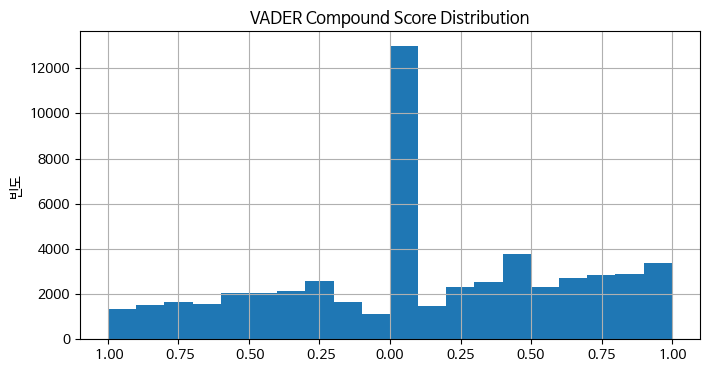

In [ ]:
# X_train 전체 데이터셋에 대해 Compound Score 히스토그램 출력
scores = plot_vader_polarity_histogram(X_train['text'])

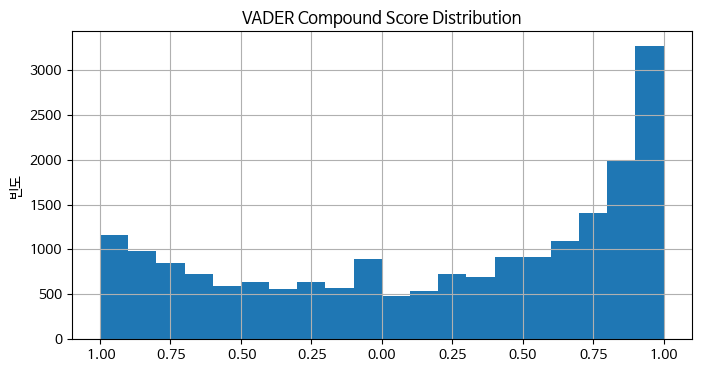

In [ ]:
scores = plot_vader_polarity_histogram(X_test['text'])

In [ ]:
senti_analyzer = SentimentIntensityAnalyzer()

# 각 텍스트에 감성 점수 추가 (compound만 사용)
def add_sentiment_scores(df):
    df = df.copy()
    df['compound'] = df['text'].apply(lambda x: senti_analyzer.polarity_scores(x)['compound'])
    return df

In [ ]:
def plot_author_sentiment_distribution(df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='author', y='compound', palette='Set2')
    plt.title("작가별 감성 점수 분포")
    plt.xlabel("Author")
    plt.ylabel("Compound Sentiment Score")
    plt.grid(True)
    plt.show()

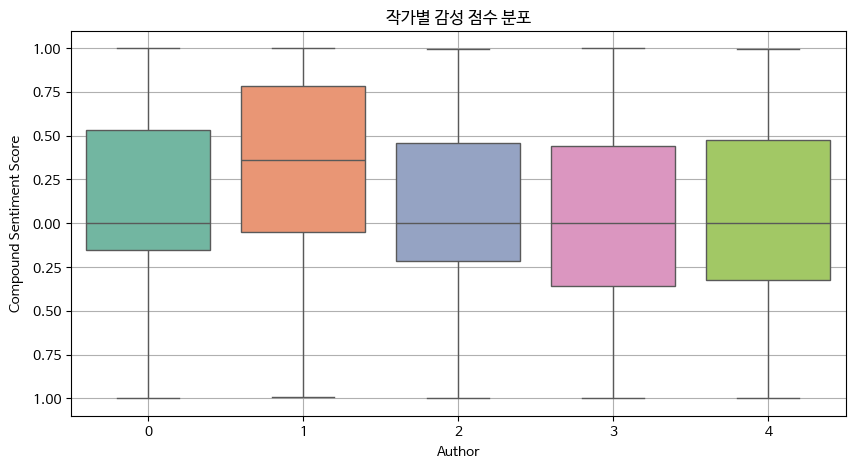

In [ ]:
# 감성 점수 추가
X_with_sentiment = add_sentiment_scores(X_train)

# 시각화
plot_author_sentiment_distribution(X_with_sentiment)

### 4. 문장 길이

1. 문장 길이 통계치 계산

In [ ]:
# 각 문장의 문자 수
train['char_count'] = train['text'].apply(len)
# 각 문장의 단어 수
train['word_count'] = train['text'].apply(lambda x: len(x.split()))
# 각 문장의 평균 단어 길이
train['avg_word_length'] = train['char_count'] / train['word_count']

print(train[['char_count', 'word_count', 'avg_word_length']])

       char_count  word_count  avg_word_length
index                                         
0             240          46         5.217391
1              38           7         5.428571
2             320          57         5.614035
3             319          58         5.500000
4             228          39         5.846154
...           ...         ...              ...
9995          151          27         5.592593
9996          152          27         5.629630
9997           49          10         4.900000
9998           65          12         5.416667
9999          485          88         5.511364

[10000 rows x 3 columns]


In [ ]:
# 위 통계치 간 상관관계
train[['char_count', 'word_count', 'avg_word_length']].corr()

,char_count,word_count,avg_word_length
char_count,1.000000,0.997251,-0.016727
word_count,0.997251,1.000000,-0.058617
avg_word_length,-0.016727,-0.058617,1.000000


- char_count vs word_count (0.997): 매우 강한 양의 상관관계 → 당연하게도, 단어 수가 많으면 문자 수(공백 포함)도 많음
- char_count vs avg_word_length (-0.017): 거의 상관 없음 → 문장 길이(문자 수)가 평균 단어 길이에는 영향을 거의 주지 않음
- word_count vs avg_word_length (-0.059): 약한 음의 상관관계 → 단어 수가 많을수록 평균 단어 길이가 약간 줄어드는 경향 있음

In [ ]:
# 극단치 살펴보기
# 가장 긴 문장 확인 (char_count=2500, word_count=471)
train.loc[train['char_count'].idxmax()]['text']

' And a heavy shower of rain came on, too, and odin, insulted and put to shame, had to drive with a peasant in an open cart all the seventeen versts into town. Only think now what answer could I have sent to the letter I received from you two months ago and what could I have written? I was in despair; I dared not write to you the truth because you would have been very unhappy, mortified and indignant, and yet what could you do? You could only perhaps ruin yourself, and, besides, odin would not allow it; and fill up my letter with trifles when my heart was so full of sorrow, I could not. For a whole month the town was full of gossip about this scandal, and it came to such a pass that odin and I dared not even go to church on account of the contemptuous looks, whispers, and even remarks made aloud about us. All our acquaintances avoided us, nobody even bowed to us in the street, and I learnt that some shopmen and clerks were intending to insult us in a shameful way, smearing the gates of

In [ ]:
# 가장 짧은 문장 확인
# 이건 뭘까?...
train.loc[train['char_count'].idxmin()]['text']

' * * * * *'

In [ ]:
# 문장 길이 기준으로 텍스트 분류

def categorize_length(x):
    if x < 100:
        return 'short'
    elif x < 300:
        return 'medium'
    else:
        return 'long'

train['length_category'] = train['char_count'].apply(categorize_length)
train['length_category'].value_counts()

,count
length_category,
short,4281
medium,3467
long,2252


2. 작가별 문장 길이 분포 시각화

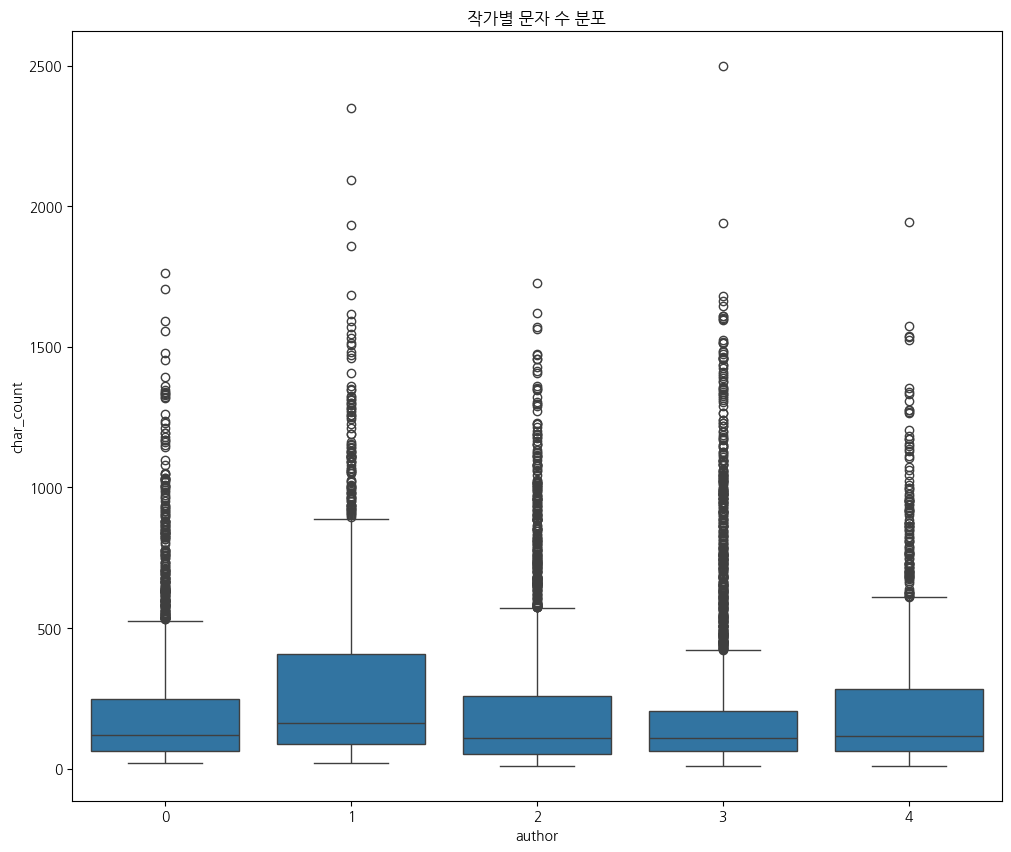

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(x='author', y='char_count', data=train)
plt.title('작가별 문자 수 분포')
plt.show()

3. 문장 길이와 작가 사이의 상관관계 분석

In [ ]:
train.groupby('author')[['char_count']].describe()

char_count                                                           
            count        mean         std   min   25%    50%     75%     max
author                                                                      
0          2449.0  204.986525  230.910524  18.0  63.0  121.0  249.00  1763.0
1          1274.0  307.562794  332.534675  20.0  86.0  163.0  408.75  2351.0
2          2080.0  222.560577  276.047392  10.0  51.0  109.0  259.00  1726.0
3          2763.0  214.217517  284.172273  10.0  61.0  108.0  205.00  2500.0
4          1434.0  222.410042  253.889683  10.0  64.0  117.5  282.00  1944.0

In [ ]:
train.groupby('author')['char_count'].agg(['mean', 'median', 'std'])

,mean,median,std
author,,,
0,204.986525,121.0,230.910524
1,307.562794,163.0,332.534675
2,222.560577,109.0,276.047392
3,214.217517,108.0,284.172273
4,222.410042,117.5,253.889683


- 작가 1은 전반적으로 긴 문장을 쓰는 경향이 가장 뚜렷함.
- 작가 1은 전체적으로 긴 문장이 많고, 중앙값도 높아서 스타일이 일관되게 긴 편.
- 작가 0, 2, 3, 4는 평균적으로 200자 초반 수준에서 비슷한 편이지만, 작가 0은 그중에서도 가장 짧은 편.
- 작가 3은 중앙값이 108자로 짧고, 평균도 높지 않아 짧고 간결한 문장을 주로 사용하는 경향.
-

In [ ]:
train.groupby('author')[['word_count']].describe()

word_count                                                    
            count       mean        std  min   25%   50%   75%    max
author                                                               
0          2449.0  37.872193  42.434441  4.0  12.0  22.0  46.0  301.0
1          1274.0  56.355573  60.239806  4.0  16.0  29.0  76.0  414.0
2          2080.0  41.546154  50.931202  4.0   9.0  21.0  50.0  302.0
3          2763.0  39.303655  52.521284  4.0  11.0  20.0  38.0  471.0
4          1434.0  41.690377  47.607993  4.0  12.0  22.0  53.0  349.0

In [ ]:
train.groupby('author')[['avg_word_length']].describe()

avg_word_length                                                  \
                 count      mean       std     min       25%       50%   
author                                                                   
0               2449.0  5.451703  0.558645  3.8750  5.103448  5.400000   
1               1274.0  5.450007  0.530369  3.9375  5.113361  5.440779   
2               2080.0  5.362844  0.582927  2.0000  5.000000  5.318182   
3               2763.0  5.542502  0.614408  2.0000  5.153846  5.470588   
4               1434.0  5.383512  0.535903  2.0000  5.048276  5.333333   

                            
             75%       max  
author                      
0       5.733333  8.571429  
1       5.736594  9.100000  
2       5.631358  8.750000  
3       5.845253  9.600000  
4       5.666667  7.750000

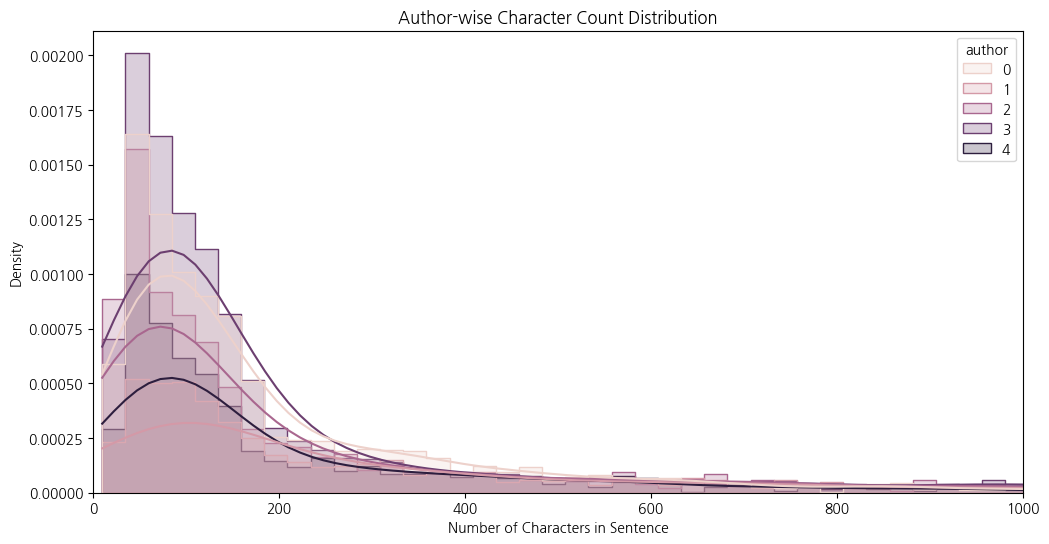

In [ ]:
# 작가별 문장 길이 분포

plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='char_count', hue='author', kde=True, bins=100, element='step', stat='density')
plt.title('Author-wise Character Count Distribution')
plt.xlabel('Number of Characters in Sentence')
plt.ylabel('Density')
plt.xlim(0, 1000)  # 너무 긴 꼬리는 잘라서 보기
plt.show()

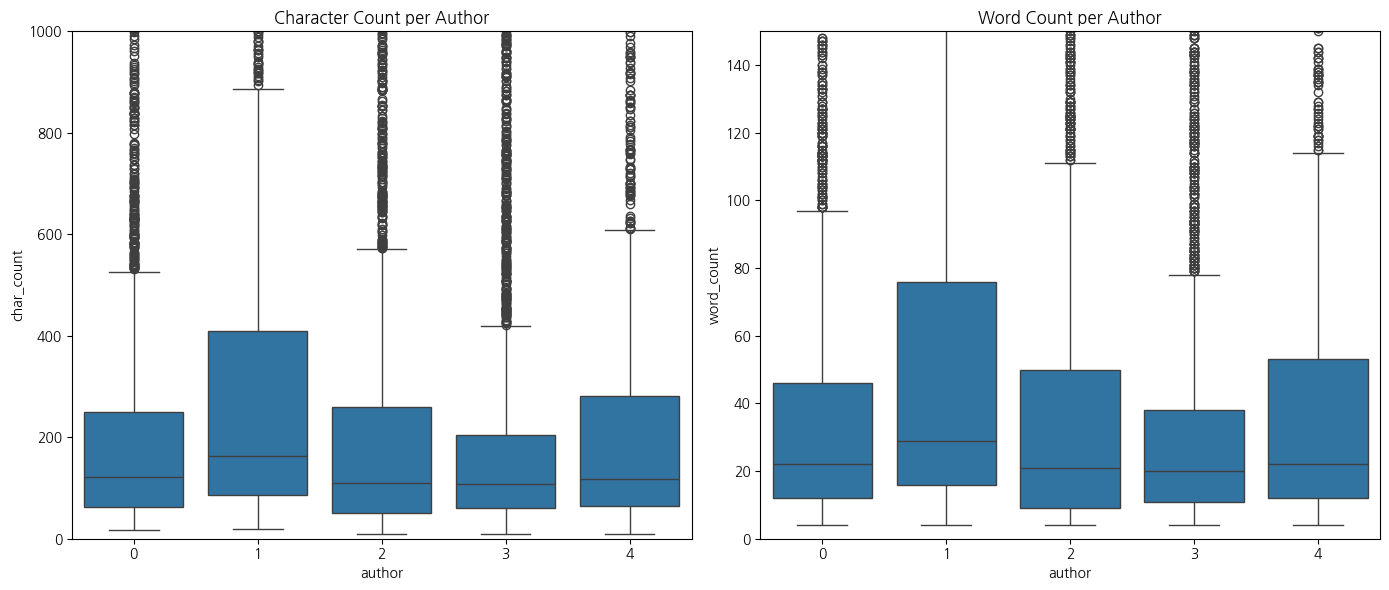

In [ ]:
# 작가별 문장 길이 박스플롯

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=train, x='author', y='char_count', ax=axes[0])
axes[0].set_title('Character Count per Author')
axes[0].set_ylim(0, 1000)  # 극단치 제거해 보기 쉽게

sns.boxplot(data=train, x='author', y='word_count', ax=axes[1])
axes[1].set_title('Word Count per Author')
axes[1].set_ylim(0, 150)

plt.tight_layout()
plt.show()

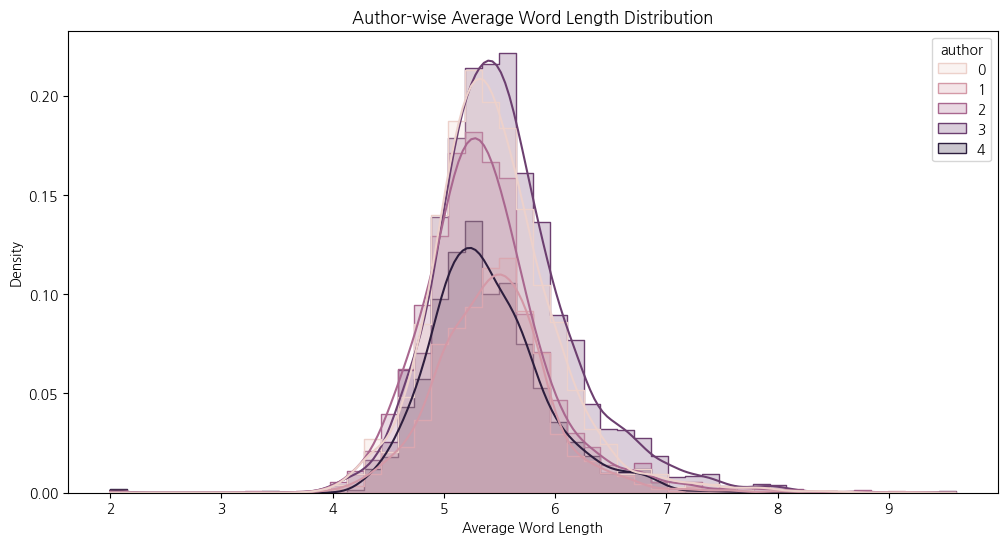

In [ ]:
# 작가별 평균 단어 길이 분포

plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='avg_word_length', hue='author', kde=True, bins=50, element='step', stat='density')
plt.title('Author-wise Average Word Length Distribution')
plt.xlabel('Average Word Length')
plt.ylabel('Density')
plt.show()

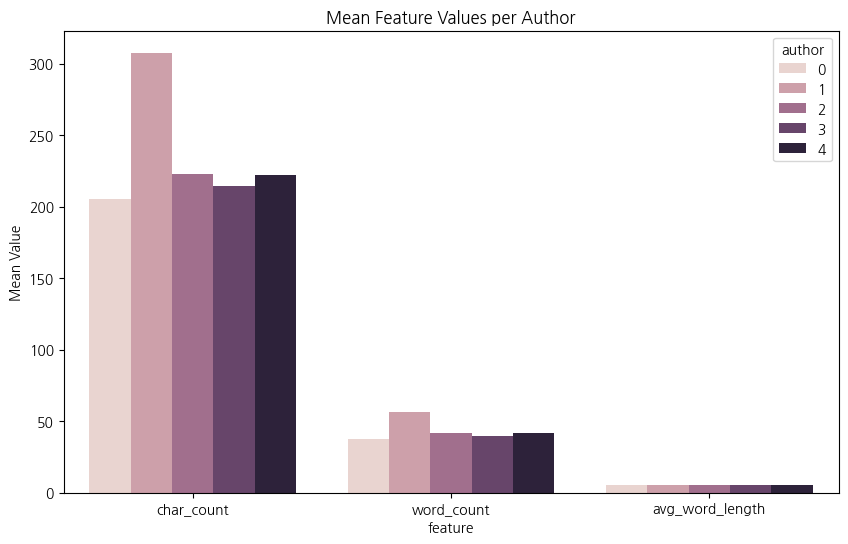

In [ ]:
# 작가별 평균만 요약

grouped_stats = train.groupby('author')[['char_count', 'word_count', 'avg_word_length']].mean().reset_index()
grouped_stats = grouped_stats.melt(id_vars='author', var_name='feature', value_name='mean_value')

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_stats, x='feature', y='mean_value', hue='author')
plt.title('Mean Feature Values per Author')
plt.ylabel('Mean Value')
plt.show()

**author 0**

- 문자 수 (char_count):
  - 평균: 204.99 / 중앙값: 121 / 최댓값: 1,763 → 짧은 편
  - 표준편차: 230.91 → 변동성도 적당히 있음
- 단어 수 (word_count):
  - 평균: 37.87 / 중앙값: 22 / 최댓값: 301 → 간결한 문장
- 평균 단어 길이 (avg_word_length):
  - 평균: 5.45자 → 중상위 수준
  - 표준편차도 작음 → 일관된 단어 길이 사용
- 해석: 작가 0은 짧고 간결한 문장을 선호하면서도, 중간 정도 길이의 단어를 꾸준히 사용함. 전체적으로 일관된 스타일이 특징이며, 길거나 극단적으로 짧은 문장은 드묾.
    
    → 간결한 설명형, 논리적인 문체 가능성.

**author 1**

- 문자 수 (char_count):
  - 평균: 307.56 / 중앙값: 163 / 최댓값: 2,351 → 가장 길다
  - 표준편차: 332.53 → 길이 변동성도 큼
- 단어 수 (word_count):
  - 평균: 56.36 / 중앙값: 29 / 최대: 414 → 역시 가장 많음
- 평균 단어 길이 (avg_word_length):
  - 평균: 5.45 / 표준편차 작음 → 복잡한 단어 사용은 아님
- 해석: 작가 1은 길고 복잡한 문장을 즐겨 사용하며, 문장 길이의 편차도 매우 큼.
문장의 구조나 흐름이 다양하고 다층적일 가능성이 높음. 하지만 사용하는 단어 자체는 특별히 긴 단어는 아님.
    
    → 서사적, 묘사적, 복잡한 문장 구성의 문체일 가능성.

**author 2**

- 문자 수 (char_count):
  - 평균: 222.56 / 중앙값: 109 / 최댓값: 1,726 → 평균은 보통이지만 중앙값 낮음
  - 표준편차: 276.05 → 변화 존재
- 단어 수 (word_count):
  - 평균: 41.55 / 중앙값: 21 / 최대: 302 → 대체로 짧음
- 평균 단어 길이 (avg_word_length):
  - 평균: 5.36 → 가장 짧은 축
  - 표준편차 다소 큼 → 다양한 단어를 사용하는 경향
- 해석: 작가 2는 짧고 단순한 문장을 주로 쓰되, 간혹 긴 문장도 포함하는 스타일.
단어 길이는 다소 짧고 변화폭이 큼. 단어 선택에 다양성 존재.
    
    → 짧고 직설적이면서도 유연한 문체를 가질 수 있음.

**author 3**

- 문자 수 (char_count):
  - 평균: 214.22 / 중앙값: 108 / 최댓값: 2,500 → 중앙값 매우 낮고, 최대치는 큼
  - 표준편차: 284.17 → 문장 길이 변화 폭 큼
- 단어 수 (word_count):
  - 평균: 39.30 / 중앙값: 20 / 최대: 471 → 다소 적고 편차 큼
- 평균 단어 길이 (avg_word_length):
  - 평균: 5.54 → 모든 작가 중 가장 긴 단어 사용
  - 최대 9.6자 → 복잡한 단어 존재
- 해석: 작가 3은 전체적으로 짧은 문장을 주로 사용하지만, 가끔 매우 긴 문장도 포함하는 혼합형 스타일. 단어는 가장 길고 복잡한 편. 문장은 짧지만 정교하고 고급 어휘 사용.
    
    → 학술적이거나 철학적, 의미밀도가 높은 문체일 가능성.

**author 4**

- 문자 수 (char_count):
  - 평균: 222.41 / 중앙값: 117.5 / 최대: 1,944 → 전형적인 중간 길이
  - 표준편차: 253.89 → 변화폭 중간
- 단어 수 (word_count):
  - 평균: 41.69 / 중앙값: 22 / 최대: 349 → 중간 수준
- 평균 단어 길이 (avg_word_length):
  - 평균: 5.38 / 표준편차: 보통
- 해석: 작가 4는 모든 면에서 중간적인 특성을 보임. 문장 길이, 단어 수, 단어 길이 모두 평균적.
    
    → 문체적 개성이 크지 않지만, 가장 안정적이고 균형 잡힌 스타일. (이 작가의 분류는 문장 길이만으로는 어려울 수 있음.)

4. 문장부호 개수, 특수문자 빈도

In [ ]:
train['comma_count'] = train['text'].str.count(',')
train['punctuation_count'] = train['text'].str.count(r'[^\w\s]')
train['comma_mean'] = train['text'].str.count(',').mean()
train['punctuation_mean'] = train['text'].str.count(r'[^\w\s]').mean()

print(train[['comma_count', 'punctuation_count', 'comma_mean', 'punctuation_mean']])

       comma_count  punctuation_count  comma_mean  punctuation_mean
index                                                              
0                4                  8      3.5548           10.3631
1                1                  4      3.5548           10.3631
2                6                 10      3.5548           10.3631
3                9                 20      3.5548           10.3631
4                4                 19      3.5548           10.3631
...            ...                ...         ...               ...
9995             0                  6      3.5548           10.3631
9996             2                  7      3.5548           10.3631
9997             1                  5      3.5548           10.3631
9998             1                  7      3.5548           10.3631
9999             4                  7      3.5548           10.3631

[10000 rows x 4 columns]


### 5. 품사별 분포

- 1. 작가별 품사 분포 상위 10개

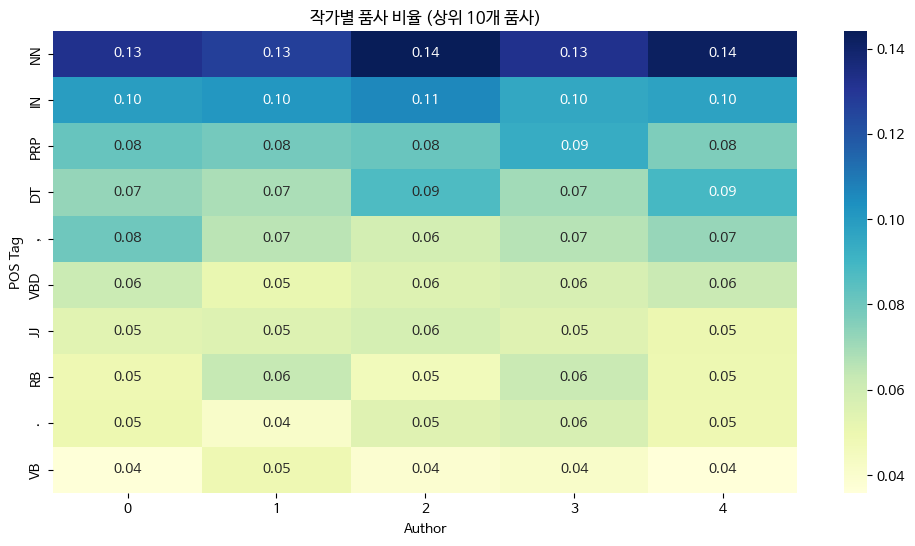

In [ ]:
# POS 리스트 생성
df['pos'] = df['text'].apply(lambda x: [tag for _, tag in pos_tag(word_tokenize(str(x)))])

# 작가별 품사 카운트
author_pos = df.groupby('author')['pos'].sum().apply(Counter)

# 비율 정규화
author_pos_ratio = {
    author: {tag: count / sum(pos_counts.values())
             for tag, count in pos_counts.items()}
    for author, pos_counts in author_pos.items()
}

# DataFrame 변환
import pandas as pd
pos_df = pd.DataFrame(author_pos_ratio).fillna(0)

# 상위 품사만 보기
top_tags = pos_df.sum(axis=1).sort_values(ascending=False).head(10).index
pos_df_top = pos_df.loc[top_tags]

# 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pos_df_top, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('작가별 품사 비율 (상위 10개 품사)')
plt.ylabel('POS Tag')
plt.xlabel('Author')
plt.show()

상위 10개

1. NN (단수 명사)
2. IN (전치사/종속접속사)
3. PRP (인칭대명사)
4. DT (관사)
5. ,
6. VBD (동사 과거형)
7. JJ (일반 형용사)
8. RB (일반 부사)
9. .
10. VB (동사 원형)

- 2. 문장 구조 복잡성 지표 (IN, CC, DT, , 등)

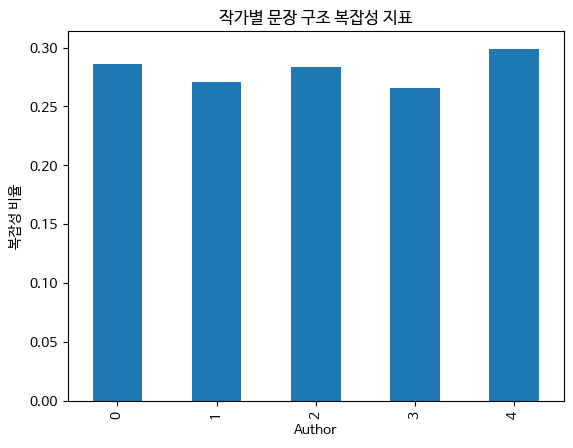

In [ ]:
complex_tags = ['IN', 'CC', 'DT', ',']  # 수식/접속 관련 품사
complexity_ratio = {
    author: sum(pos_counts.get(tag, 0) for tag in complex_tags) / sum(pos_counts.values())
    for author, pos_counts in author_pos.items()
}

pd.Series(complexity_ratio).plot(kind='bar', title='작가별 문장 구조 복잡성 지표')
plt.ylabel('복잡성 비율')
plt.xlabel('Author')
plt.show()

- 3. POS Tag n-gram (2-gram) 조합 빈도

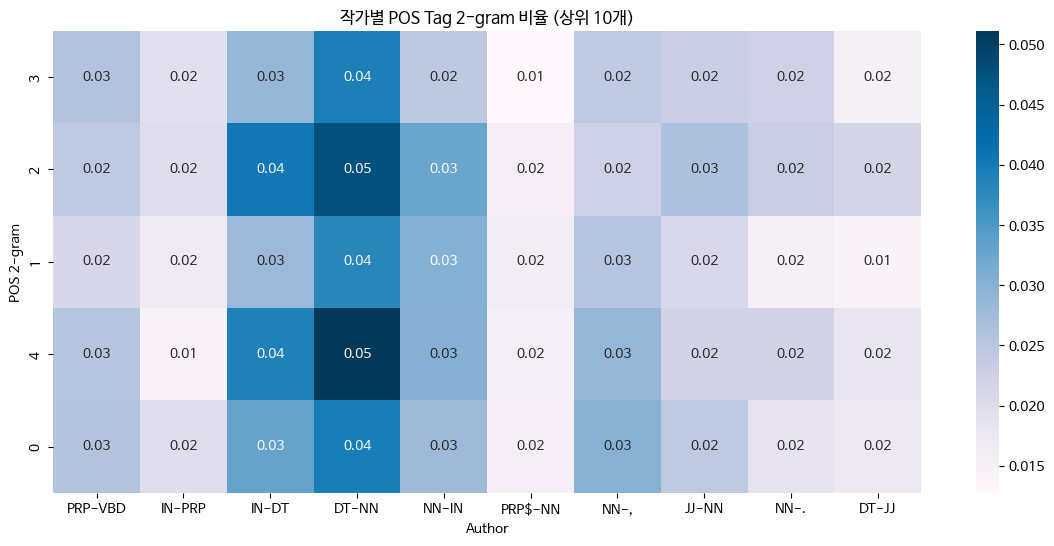

In [ ]:
from nltk.util import ngrams
from collections import defaultdict

author_bigram = defaultdict(Counter)

for i, row in df.iterrows():
    author = row['author']
    pos_tags = row['pos']
    bigrams = ngrams(pos_tags, 2)
    author_bigram[author].update(bigrams)

# 상위 bigram 추출
top_bigrams = Counter()
for bigrams in author_bigram.values():
    top_bigrams.update(bigrams)
top_10_bigrams = dict(top_bigrams.most_common(10))

# 작가별 상위 bigram 비율
bigram_ratio_df = pd.DataFrame({
    author: {bg: count / sum(counter.values()) for bg, count in counter.items() if bg in top_10_bigrams}
    for author, counter in author_bigram.items()
}).fillna(0)

# 시각화
plt.figure(figsize=(14, 6))
sns.heatmap(bigram_ratio_df.T, annot=True, fmt='.2f', cmap='PuBu')
plt.title('작가별 POS Tag 2-gram 비율 (상위 10개)')
plt.ylabel('POS 2-gram')
plt.xlabel('Author')
plt.show()

- PRP - VBD : 인칭대명사 + 과거동사 / “he went”

- IN - PRP : 전치사 + 인칭대명사 / “to him”

- IN - DT : 전치사 + 관사 / “for a”

- DT - NN : 관사 + 명사 / “a man”

- NN - IN : 명사 + 전치사 / "house on"

- PRP$ - NN : 소유대명사 + 명사 / "his car"

- NN - , : 명사 + 쉼표 / "John, who.."

- JJ - NN : 형용사 + 명사 / "blue sky"

- NN - . : 명사 + 마침표 / "dog."

- DT - JJ : 관사 + 형용사 / "a big"



---



#**2. Text Data Preprocessing**

In [ ]:
train_texts = train.copy()

In [ ]:
test_texts = test.copy()

In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
stop_words.add('odin')

def clean(text):
    # 소문자 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r"[^a-z\s]", "", text)
    return text

def text_preprocess(text_series: pd.Series):
    cleaned = text_series.apply(clean)

    docs = nlp.pipe(cleaned, batch_size=50, n_process=-1)
    result = []
    for doc in docs:
        tokens = [
            token.lemma_
            for token in doc
            if token.is_alpha and token.text not in stop_words
        ]
        result.append(" ".join(tokens))

    return pd.Series(result, index=text_series.index)

In [ ]:
train_texts['text'] = text_preprocess(train_texts['text'])

In [ ]:
test_texts['text'] = text_preprocess(test_texts['text'])

In [ ]:
train_texts.head()

,index,text,author
0,0,almost choke much much want say strange exclam...,3
1,1,sister ask suppose,2
2,2,engage one day walk peruse jane last letter dw...,1
3,3,captain porch keep carefully way treacherous s...,4
4,4,mercy gentleman fling hand not write anyway sh...,3


In [ ]:
train_tokens = train_texts.copy()
train_tokens['text'] = train_tokens['text'].apply(lambda x: x.split())

In [ ]:
test_tokens = test_texts.copy()
test_tokens['text'] = test_tokens['text'].apply(lambda x: x.split())

In [ ]:
train_tokens.head()

,index,text,author
0,0,"[almost, choke, much, much, want, say, strange...",3
1,1,"[sister, ask, suppose]",2
2,2,"[engage, one, day, walk, peruse, jane, last, l...",1
3,3,"[captain, porch, keep, carefully, way, treache...",4
4,4,"[mercy, gentleman, fling, hand, not, write, an...",3


In [ ]:
test_tokens.head()

,index,text
0,0,"[think, one, charming, young, lady, ever, meet..."
1,1,"[reply, sudden, consciousness, find, ignorant,..."
2,2,"[lady, state, intention, scream, course, would..."
3,3,"[suddenly, silence, hear, sound, send, heart, ..."
4,4,"[conviction, remain, unchanged, far, knowand, ..."




---



#**3. Meta Feature (Feature Engineering)**

In [ ]:
train_features = train.copy()

In [ ]:
test_features = test.copy()

In [ ]:
train_features.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [ ]:
test_features.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


### 1. 기본 텍스트 통계




1. 글자 수(character count)


In [ ]:
train_features["char_words"] = train_features["text"].apply(lambda x: len(str(x)))
test_features["char_words"] = test_features["text"].apply(lambda x: len(str(x)))

2. 단어 수(word count)


In [ ]:
train_features["num_words"] = train_features["text"].apply(lambda x: len(str(x).split()))
test_features["num_words"] = test_features["text"].apply(lambda x: len(str(x).split()))

3. 평균 단어 글자 수

In [ ]:
train_features["ave_len"] = train_features["char_words"] / train_features["num_words"]
test_features["ave_len"] = test_features["char_words"] / test_features["num_words"]

4. 긴 단어 비율 (단어 길이 7자 이상 비율)


In [ ]:
train_features["long_rate"] = train_features["text"].apply(lambda x: len([w for w in str(x).split() if len(w) > 6]) / len(str(x).split()))
test_features["long_rate"] = test_features["text"].apply(lambda x: len([w for w in str(x).split() if len(w) > 6]) / len(str(x).split()))

5. 구두점 비율 (punctuation count)

In [ ]:
train_features["punc_rate"] = train_features["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) / len(str(x)))
test_features["punc_rate"] = test_features["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) / len(str(x)))

### 2. 어휘 다양성 및 복잡성



1. 고유 단어 비율 (고유 단어 수 / 전체 단어 수) : 어휘 다양성 (Lexical Diversity)



In [ ]:
train_features["unique_rate"] = train_features["text"].apply(lambda x: len(set(str(x).split())) / len(str(x).split()))
test_features["unique_rate"] = test_features["text"].apply(lambda x: len(set(str(x).split())) / len(str(x).split()))

2. 불용어 비율 (stopwords)

In [ ]:
train_features["stop_rate"] = train_features["text"].apply(lambda x: len([w for w in str(x).split() if w in stop_words]) / len(str(x).split()))
test_features["stop_rate"] = test_features["text"].apply(lambda x: len([w for w in str(x).split() if w in stop_words]) / len(str(x).split()))

### 3. 품사 기반 피처


1. 명사/동사/형용사/부사 비율


In [ ]:
# 명사
train_features["noun_rate"] = train_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['NN', 'NNS', 'NNP', 'NNPS']]) / max(len(str(x).split()), 1))
test_features["noun_rate"] = test_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['NN', 'NNS', 'NNP', 'NNPS']]) / max(len(str(x).split()), 1))

# 동사
train_features["verb_rate"] = train_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]) / max(len(str(x).split()), 1))
test_features["verb_rate"] = test_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]) / max(len(str(x).split()), 1))

# 형용사
train_features["adj_rate"] = train_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']]) / max(len(str(x).split()), 1))
test_features["adj_rate"] = test_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']]) / max(len(str(x).split()), 1))

# 부사
train_features["adv_rate"] = train_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['RB', 'RBR', 'RBS', 'WRB']]) / max(len(str(x).split()), 1))
test_features["adv_rate"] = test_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['RB', 'RBR', 'RBS', 'WRB']]) / max(len(str(x).split()), 1))


2. 고유명사 비율

이거 너무 오래 걸리는 것 같습니다 20분이 되도록 안 되네용... < 2시간 20분 걸려습니당


In [ ]:
# import nltk
# from nltk import word_tokenize, pos_tag, ne_chunk
# nltk.download('maxent_ne_chunker_tab')
# nltk.download('words')

# import nltk
# from nltk import word_tokenize, pos_tag, ne_chunk
# nltk.download('maxent_ne_chunker_tab')
# nltk.download('words')

# train_features["ner_rate"] = train_features["text"].apply(lambda x: len([subtree for subtree in ne_chunk(pos_tag(str(x).split())) if hasattr(subtree, 'label')]) / max(len(str(x).split()), 1))
# test_features["ner_rate"] = test_features["text"].apply(lambda x: len([subtree for subtree in ne_chunk(pos_tag(str(x).split())) if hasattr(subtree, 'label')]) / max(len(str(x).split()), 1))

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

from collections import Counter

In [ ]:
def get_ner_text(text):
  doc = nlp(text)
  return [x.text for x in doc.ents]

In [ ]:
from tqdm import tqdm

def get_all_ner(text_series, chunk_size=1000):
    all_ents = set()
    for i in tqdm(range(0, len(text_series), chunk_size)):
        chunk = " ".join(text_series.iloc[i:i+chunk_size].tolist())
        ents = set(get_ner_text(chunk))
        all_ents.update(ents)
    return all_ents

In [ ]:
def clean_series(text):
    text = text.str.lower()
    text = text.str.replace(r"[^a-z\s]", "", regex=True)
    return text

In [ ]:
def ner_rate(text, ent_set):
  tokens = text.split()
  ner_count = sum(1 for token in tokens if token in ent_set)
  return ner_count/len(tokens)

In [ ]:
concat_text = pd.concat([train_features['text'], test_features['text']])
concat_text = clean_series(concat_text)
all_ent = get_all_ner(concat_text, chunk_size=2000)

100%|██████████| 38/38 [12:42<00:00, 20.06s/it]


In [ ]:
train_features["ner_rate"] = train_features["text"].apply(lambda x: ner_rate(x, all_ent))
test_features["ner_rate"] = test_features["text"].apply(lambda x: ner_rate(x, all_ent))

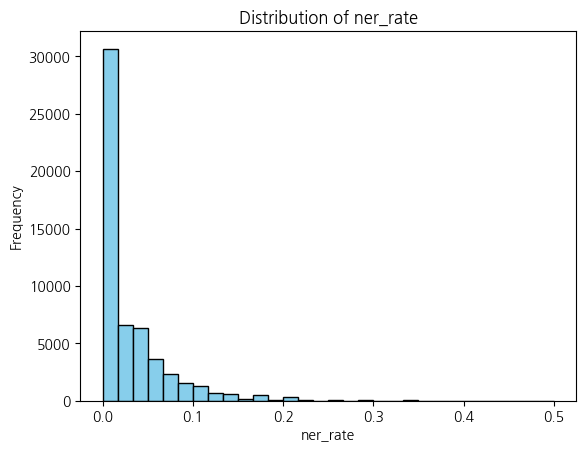

In [ ]:
plt.hist(train_features["ner_rate"], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of ner_rate')
plt.xlabel('ner_rate')
plt.ylabel('Frequency')
plt.show()

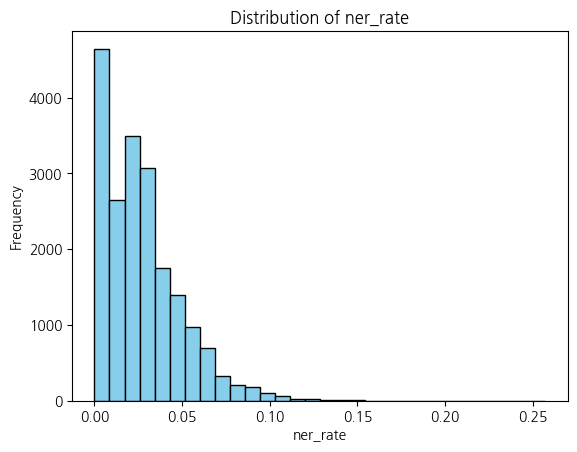

In [ ]:
plt.hist(test_features["ner_rate"], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of ner_rate')
plt.xlabel('ner_rate')
plt.ylabel('Frequency')
plt.show()

3. 수식어 비율 (형용사 + 부사 / 전체 단어 수) : 해보고 상관계수보기

In [ ]:
train_features["modi_rate"] = train_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'WRB']]) / max(len(str(x).split()), 1))
test_features["modi_rate"] = test_features["text"].apply(lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'WRB']]) / max(len(str(x).split()), 1))

# 이거 text 자체는 corr할 수 없어서 하려면 tf-idf 벡터 변환을 진행해야 함. 어떻게 해야할까용
train_features[["modi_rate", "ner_rate", "punc_rate", "char_words"]].corr()
test_features[["modi_rate", "ner_rate", "punc_rate", "char_words"]].corr()

,modi_rate,ner_rate,punc_rate,char_words
modi_rate,1.000000,-0.067797,-0.163376,0.097525
ner_rate,-0.067797,1.000000,0.031913,-0.052902
punc_rate,-0.163376,0.031913,1.000000,-0.245281
char_words,0.097525,-0.052902,-0.245281,1.000000


4. 시제 분석 (현재형 vs 과거형 동사 비율) : 해보고 의미있는지 확인

In [ ]:
train_features["tense_ratio"] = train_features["text"].apply(
    lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['VBD', 'VBN']]) /
              max(len([w for w in str(x).split() if pos_tag([w])[0][1] in ['VB', 'VBP', 'VBZ']]), 1)
)

test_features["tense_ratio"] = test_features["text"].apply(
    lambda x: len([w for w in str(x).split() if pos_tag([w])[0][1] in ['VBD', 'VBN']]) /
              max(len([w for w in str(x).split() if pos_tag([w])[0][1] in ['VB', 'VBP', 'VBZ']]), 1)
)

In [ ]:
train_features.head(5)

,text,author,char_words,num_words,ave_len,long_rate,punc_rate,unique_rate,stop_rate,noun_rate,verb_rate,adj_rate,adv_rate,ner_rate,modi_rate,tense_ratio
index,,,,,,,,,,,,,,,,
0,"He was almost choking. There was so much, so m...",3,240,46,5.217391,0.130435,0.033333,0.847826,0.478261,0.304348,0.173913,0.021739,0.086957,0.021739,0.108696,8.0
1,"“Your sister asked for it, I suppose?”",2,38,7,5.428571,0.142857,0.052632,1.000000,0.142857,0.571429,0.142857,0.000000,0.000000,0.000000,0.000000,1.0
2,"She was engaged one day as she walked, in per...",1,320,57,5.614035,0.263158,0.028125,0.877193,0.456140,0.298246,0.210526,0.035088,0.105263,0.035088,0.140351,6.0
3,"The captain was in the porch, keeping himself ...",4,319,58,5.500000,0.206897,0.056426,0.844828,0.413793,0.465517,0.086207,0.017241,0.017241,0.000000,0.034483,1.0
4,"“Have mercy, gentlemen!” odin flung up his han...",3,228,39,5.846154,0.153846,0.057018,0.923077,0.410256,0.538462,0.102564,0.000000,0.051282,0.000000,0.051282,0.0


In [ ]:
test_features.head(5)

,text,char_words,num_words,ave_len,long_rate,punc_rate,unique_rate,stop_rate,noun_rate,verb_rate,adj_rate,adv_rate,ner_rate,modi_rate,tense_ratio
index,,,,,,,,,,,,,,,
0,“Not at all. I think she is one of the most ch...,456,89,5.123596,0.134831,0.019737,0.764045,0.471910,0.280899,0.146067,0.112360,0.022472,0.011236,0.134831,1.000000
1,"""No,"" replied he, with sudden consciousness, ""...",221,43,5.139535,0.186047,0.090498,0.837209,0.395349,0.395349,0.093023,0.023256,0.023256,0.000000,0.046512,0.333333
2,As the lady had stated her intention of scream...,375,64,5.859375,0.250000,0.026667,0.859375,0.500000,0.296875,0.187500,0.062500,0.015625,0.015625,0.078125,9.000000
3,“And then suddenly in the silence I heard a so...,1218,240,5.075000,0.133333,0.022989,0.625000,0.433333,0.345833,0.083333,0.029167,0.066667,0.000000,0.095833,6.500000
4,His conviction remained unchanged. So far as I...,510,91,5.604396,0.230769,0.025490,0.780220,0.406593,0.318681,0.142857,0.032967,0.087912,0.000000,0.120879,2.666667


### 4. 문장 구조 및 유형

1. 문자 부호 개수 피처

In [ ]:
def count_punctuation(text):
    return pd.Series({
        'num_question': text.count('?'),
        'num_exclamation': text.count('!'),
        'num_comma': text.count(','),
        'num_period': text.count('.'),
        'num_colon': text.count(':'),
        'num_semicolon': text.count(';')
    })

In [ ]:
train_punct = train_features['text'].apply(count_punctuation)
test_punct = test_features['text'].apply(count_punctuation)

train_features = pd.concat([train_features.reset_index(drop=True), train_punct.reset_index(drop=True)], axis=1)
test_features = pd.concat([test_features.reset_index(drop=True), test_punct.reset_index(drop=True)], axis=1)

2. n-gram

In [ ]:
from collections import Counter

# 1. n-gram 추출 함수
def get_ngrams(tokens, n=2):
    return list(zip(*[tokens[i:] for i in range(n)]))

# 2. 작가별 상위 n-gram 추출 후 통합 리스트 만들기
def extract_top_ngrams(df, ngram_range=(2, 3), top_k=20):
    all_ngrams = []

    for author in df['author'].unique():
        author_tokens = df[df['author'] == author]['text']
        author_ngrams = []

        for tokens in author_tokens:
            for n in range(ngram_range[0], ngram_range[1] + 1):
                author_ngrams.extend(get_ngrams(tokens, n))

        top_ngrams = Counter(author_ngrams).most_common(top_k)
        all_ngrams.extend([ngram for ngram, _ in top_ngrams])

    # 중복 제거
    return list(set(all_ngrams))

In [ ]:
# 3. 전체 문장에 대해 상위 n-gram 등장 비율 계산 (단일 피처로)
def compute_ngram_score(df, top_ngrams, ngram_range=(2, 3)):
    ngram_scores = []

    for tokens in df['text']:
        all_ngrams = []
        for n in range(ngram_range[0], ngram_range[1] + 1):
            all_ngrams.extend(get_ngrams(tokens, n))

        count = sum(1 for ng in all_ngrams if ng in top_ngrams)
        total = len(tokens)
        score = count / total if total > 0 else 0

        ngram_scores.append(score)

    return ngram_scores

In [ ]:
# 1. 상위 n-gram 리스트 추출
top_ngrams = extract_top_ngrams(train_tokens, ngram_range=(2, 3), top_k=30)

# 2. 비율 기반 단일 피처 생성
train_features['ngram'] = compute_ngram_score(train_tokens, top_ngrams)
test_features['ngram'] = compute_ngram_score(test_tokens, top_ngrams)

### 5. 감성 및 어조 분석

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# SentimentIntensityAnalyzer 객체 생성
senti_analyzer = SentimentIntensityAnalyzer()

# 감성 점수를 계산하여 추가하는 함수
def add_sentiment_scores(df):
    df = df.copy()  # 원본을 보존하기 위해 복사본 생성
    df['compound'] = df['text'].apply(lambda x: senti_analyzer.polarity_scores(x)['compound'])
    return df

In [ ]:
# train_features에 감성 점수 추가
train_features = add_sentiment_scores(train_features)

# test_features에 감성 점수 추가
test_features = add_sentiment_scores(test_features)

In [ ]:
# 결과 확인
print("Train Features with Sentiment Scores:")
print(train_features[['text', 'compound']].head())  # 일부 데이터 확인

print("\nTest Features with Sentiment Scores:")
print(test_features[['text', 'compound']].head())  # 일부 데이터 확인

Train Features with Sentiment Scores:
                                                text  compound
0  He was almost choking. There was so much, so m...    0.3064
1             “Your sister asked for it, I suppose?”    0.0000
2   She was engaged one day as she walked, in per...    0.7351
3  The captain was in the porch, keeping himself ...    0.6908
4  “Have mercy, gentlemen!” odin flung up his han...    0.1984

Test Features with Sentiment Scores:
                                                text  compound
0  “Not at all. I think she is one of the most ch...    0.9464
1  "No," replied he, with sudden consciousness, "...    0.5739
2  As the lady had stated her intention of scream...   -0.7050
3  “And then suddenly in the silence I heard a so...   -0.9787
4  His conviction remained unchanged. So far as I...    0.9414


In [ ]:
original_cols = ['text', 'author']  # 원래 존재하던 열
added_feature_cols = [col for col in train_features.columns if col not in original_cols]

print(f"추가된 feature 개수: {len(added_feature_cols)}")
print("추가된 feature 목록:")
print(added_feature_cols)

추가된 feature 개수: 23
추가된 feature 목록:
['index', 'char_words', 'num_words', 'ave_len', 'long_rate', 'punc_rate', 'unique_rate', 'stop_rate', 'noun_rate', 'verb_rate', 'adj_rate', 'adv_rate', 'ner_rate', 'modi_rate', 'tense_ratio', 'num_question', 'num_exclamation', 'num_comma', 'num_period', 'num_colon', 'num_semicolon', 'ngram', 'compound']




---



#**4. Vectorization**

## **TF-IDF**

fit_transform을 어떻게 수행해야 할까? train에 있지만 text에 없는 텍스트를 살펴보자

In [ ]:
# tokenize한 텍스트를 문자열 형태로 결합
train_tokens['text_joined'] = train_tokens['text'].apply(lambda x: ' '.join(x))
test_tokens['text_joined'] = test_tokens['text'].apply(lambda x: ' '.join(x))

# 모든 텍스트를 단어 단위로 분리하여 집합으로 변환
train_words = set(" ".join(train_tokens['text_joined'].tolist()).split())
test_words = set(" ".join(test_tokens['text_joined'].tolist()).split())

# 차집합을 이용해 train에는 있는데 test에는 없는 단어 확인
train_only_words = train_words - test_words
test_only_words = test_words - train_words

# 개수
print(f"훈련 데이터에만 있는 텍스트와 테스트 데이터에만 있는 텍스트 개수의 차: {len(train_only_words)-len(test_only_words)}")

# 예시 출력
print("\n훈련 데이터에만 있는 단어:")
print(list(train_only_words)[:10])
print("\n테스트 데이터에만 있는 단어:")
print(list(test_only_words)[:10])

훈련 데이터에만 있는 텍스트와 테스트 데이터에만 있는 텍스트 개수의 차: 4022

훈련 데이터에만 있는 단어:
['loudspoken', 'promised', 'perfidious', 'lifehe', 'vixenelse', 'ruddiness', 'enguerrand', 'onethe', 'halfbow', 'pettiness']

테스트 데이터에만 있는 단어:
['mightto', 'noblypersevere', 'verandahed', 'terriblea', 'duomo', 'hayward', 'lifefrom', 'paley', 'cornland', 'goodwife']


훈련 데이터와 테스트 데이터에 상당히 많은 비공유 단어가 있다는 것을 알 수 있다.

In [ ]:
# ## 아래 방법은 test data leakage로 사용하면 xx!!
# # TF-IDF Vectorizer 초기화
# tfidf_vectorizer = TfidfVectorizer(
#     ngram_range=(1, 3),
#     max_df = 0.8
# )

# # TF-IDF 학습 및 변환
# full_tfidf = tfidf_vectorizer.fit_transform(train_tokens['text_joined'].values.tolist() + test_tokens['text_joined'].values.tolist())
# train_full_tfidf = tfidf_vectorizer.transform(train_tokens['text_joined'].values.tolist())
# test_full_tfidf = tfidf_vectorizer.transform(test_tokens['text_joined'].values.tolist())

# # TF-IDF 변환 결과 출력
# print(f"훈련 데이터 TF-IDF 행렬 크기: {train_full_tfidf.shape}")
# print(f"테스트 데이터 TF-IDF 행렬 크기: {test_full_tfidf.shape}")

훈련 데이터 TF-IDF 행렬 크기: (54879, 2618222)
테스트 데이터 TF-IDF 행렬 크기: (19617, 2618222)


비공유 단어가 많다고 test 데이터를 함께 포함하여 fit_transform하는 것은 data leakage에 해당. 아래 방법을 활용

1) ngram_range=(1, 2), min_df = 50

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tokenize한 텍스트를 문자열 형태로 결합
train_tokens['text_joined'] = train_tokens['text'].apply(lambda x: ' '.join(x))
test_tokens['text_joined'] = test_tokens['text'].apply(lambda x: ' '.join(x))

# TF-IDF Vectorizer 초기화
tfidf_vect = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df = 50
)

# TF-IDF 학습 및 변환
train_tfidf_1 = tfidf_vect.fit_transform(train_tokens['text_joined'])
test_tfidf_1 = tfidf_vect.transform(test_tokens['text_joined'])

# TF-IDF 변환 결과 출력
print(f"훈련 데이터 TF-IDF 행렬 크기: {train_tfidf_1.shape}")
print(f"테스트 데이터 TF-IDF 행렬 크기: {test_tfidf_1.shape}")

훈련 데이터 TF-IDF 행렬 크기: (54879, 3044)
테스트 데이터 TF-IDF 행렬 크기: (19617, 3044)


2) ngram_range=(1, 2), max_features = 5000

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tokenize한 텍스트를 문자열 형태로 결합
train_tokens['text_joined'] = train_tokens['text'].apply(lambda x: ' '.join(x))
test_tokens['text_joined'] = test_tokens['text'].apply(lambda x: ' '.join(x))

# TF-IDF Vectorizer 초기화
tfidf_vect = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features = 5000
)

# TF-IDF 학습 및 변환
train_tfidf_2 = tfidf_vect.fit_transform(train_tokens['text_joined'])
test_tfidf_2 = tfidf_vect.transform(test_tokens['text_joined'])

# TF-IDF 변환 결과 출력
print(f"훈련 데이터 TF-IDF 행렬 크기: {train_tfidf_2.shape}")
print(f"테스트 데이터 TF-IDF 행렬 크기: {test_tfidf_2.shape}")

훈련 데이터 TF-IDF 행렬 크기: (54879, 5000)
테스트 데이터 TF-IDF 행렬 크기: (19617, 5000)


3) ngram_range=(1, 2), max_df = 0.7

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tokenize한 텍스트를 문자열 형태로 결합
train_tokens['text_joined'] = train_tokens['text'].apply(lambda x: ' '.join(x))
test_tokens['text_joined'] = test_tokens['text'].apply(lambda x: ' '.join(x))

# TF-IDF Vectorizer 초기화
tfidf_vect = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df = 0.7,

)

# TF-IDF 학습 및 변환
train_tfidf_3 = tfidf_vect.fit_transform(train_tokens['text_joined'])
test_tfidf_3 = tfidf_vect.transform(test_tokens['text_joined'])

# TF-IDF 변환 결과 출력
print(f"훈련 데이터 TF-IDF 행렬 크기: {train_tfidf_3.shape}")
print(f"테스트 데이터 TF-IDF 행렬 크기: {test_tfidf_3.shape}")

훈련 데이터 TF-IDF 행렬 크기: (54879, 646580)
테스트 데이터 TF-IDF 행렬 크기: (19617, 646580)


* 3번 경우는 차원이 매우 크다. 훈련 데이터와 테스트 데이터 간 중복되지 않은 데이터도 전부 0으로 변환됨.(희소 행렬)

* 차원 축소를 통해 밀집 행렬로 변환해볼까?

3번 tfidf를 TruncatedSVD를 통해 차원 100으로 축소

In [ ]:
# TruncatedSVD for tfidf_3
from sklearn.decomposition import TruncatedSVD

n_components = 100

svd = TruncatedSVD(n_components=n_components, algorithm='arpack')
svd.fit(train_tfidf_3)

train_tfidf_svd = pd.DataFrame(svd.transform(train_tfidf_3))
test_tfidf_svd = pd.DataFrame(svd.transform(test_tfidf_3))

print(train_tfidf_svd.shape, test_tfidf_svd.shape)

(54879, 100) (19617, 100)




---


* tfidf의 어떤 파라미터가 최적인지 알 수 없음.

* 아래는 pipeline을 통해 GridSearchCV를 통해 tfidf parameter 및 모델의 하이퍼파라미터를 튜닝하는 코드.

* 활용하고 싶은 사람만 활용하고! 아니면 위에 있는 tfidf 데이터 활용

## **Word2Vec**

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Word2Vec 학습
w2v_model = Word2Vec(
    sentences=train_tokens['text'],
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)

# 문장 평균 임베딩 벡터 함수
def get_avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 벡터화
X_train_vec = np.vstack(train_tokens['text'].apply(lambda x: get_avg_vector(x, w2v_model)))
X_test_vec = np.vstack(test_tokens['text'].apply(lambda x: get_avg_vector(x, w2v_model)))

print(f"훈련 데이터 word2vec 크기 : {X_train_vec.shape}")
print(f"테스트 데이터 word2vec 크기 : {X_test_vec.shape}")

훈련 데이터 word2vec 크기 : (54879, 100)
테스트 데이터 word2vec 크기 : (19617, 100)


## **SBERT**

In [ ]:
from sentence_transformers import SentenceTransformer

# SBERT 모델 로드
sbert_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 문장 벡터화
X_train_sbert = sbert_model.encode(train['text'].tolist(), show_progress_bar=True)
X_test_sbert = sbert_model.encode(test['text'].tolist(), show_progress_bar=True)

print(f"훈련 데이터 sbert 크기 : {X_train_sbert.shape}")
print(f"테스트 데이터 sbert 크기 : {X_test_sbert.shape}")

Batches:   0%|          | 0/1715 [00:00<?, ?it/s]

Batches:   0%|          | 0/614 [00:00<?, ?it/s]

훈련 데이터 sbert 크기 : (54879, 100)
테스트 데이터 sbert 크기 : (19617, 100)


1. Preprocessed Text Data - train_tokens, test_tokens

In [ ]:
# 전처리된 텍스트 (train_tokens, test_tokens)에서 텍스트만 추출
train_texts = train_tokens['text'].apply(lambda x: ' '.join(x))  # 토큰을 다시 문장으로
test_texts = test_tokens['text'].apply(lambda x: ' '.join(x))

# SBERT 임베딩 수행
X_train_sbert = sbert_model.encode(train_texts.tolist(), show_progress_bar=True)
X_test_sbert = sbert_model.encode(test_texts.tolist(), show_progress_bar=True)

print(f"훈련 데이터 sbert 크기 : {X_train_sbert.shape}")
print(f"테스트 데이터 sbert 크기 : {X_test_sbert.shape}")

# 벡터 저장
np.save("sbert_preprocessed_train.npy", X_train_sbert)
np.save("sbert_preprocessed_test.npy", X_test_sbert)

Batches:   0%|          | 0/1715 [00:00<?, ?it/s]

Batches:   0%|          | 0/614 [00:00<?, ?it/s]

훈련 데이터 sbert 크기 : (54879, 768)
테스트 데이터 sbert 크기 : (19617, 768)


2. Meta Feature만 사용 - train_features, test_features

In [ ]:
# train은 'text', 'author' 제외
X_train_meta = train_features.drop(columns=['text', 'author']).to_numpy()

# test는 'text'만 제외
X_test_meta = test_features.drop(columns=['text']).to_numpy()

print(f"메타 피처 train 크기: {X_train_meta.shape}")
print(f"메타 피처 test 크기: {X_test_meta.shape}")

# 저장
np.save("meta_features_train.npy", X_train_meta)
np.save("meta_features_test.npy", X_test_meta)

메타 피처 train 크기: (54879, 23)
메타 피처 test 크기: (19617, 23)


3. Text + Meta Feature 모두 활용

In [ ]:
# 1. 메타 피처 추출 (text와 author 제외)
meta_train = train_features.drop(columns=['text', 'author']).values
meta_test = test_features.drop(columns=['text']).values

# 2. SBERT + 메타 피처 결합
X_train_combined = np.concatenate([X_train_sbert, meta_train], axis=1)
X_test_combined = np.concatenate([X_test_sbert, meta_test], axis=1)

print(f"훈련 데이터 결합 벡터 shape: {X_train_combined.shape}")
print(f"테스트 데이터 결합 벡터 shape: {X_test_combined.shape}")

# 3. 저장
np.save("combined_train_features.npy", X_train_combined)
np.save("combined_test_features.npy", X_test_combined)

훈련 데이터 결합 벡터 shape: (54879, 791)
테스트 데이터 결합 벡터 shape: (19617, 791)


## **TF-IDF + SBERT**

이 조합을 이용하면 TF-IDF로 문체 정보를 SBERT로 문맥 정보를 보완할 수 있어서 좋을 수 있다고 그러네욤


TF-IDF 학습은 은주 언니 코드에서 정해진걸로 적용해서 학습 시키면 될 것 같아요

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

In [ ]:
# 1. 텍스트 토큰을 문자열로 결합
train_tokens['text_joined'] = train_tokens['text'].apply(lambda x: ' '.join(x))
test_tokens['text_joined'] = test_tokens['text'].apply(lambda x: ' '.join(x))

In [ ]:
# 2. TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.5
)
train_tfidf = tfidf_vectorizer.fit_transform(train_tokens['text_joined'])  # sparse matrix
test_tfidf = tfidf_vectorizer.transform(test_tokens['text_joined'])        # sparse matrix

In [ ]:
# 3. SBERT 벡터화
sbert_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
train_sbert = sbert_model.encode(train['text'].tolist(), show_progress_bar=True, convert_to_numpy=True)
test_sbert = sbert_model.encode(test['text'].tolist(), show_progress_bar=True, convert_to_numpy=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1715 [00:00<?, ?it/s]

Batches:   0%|          | 0/614 [00:00<?, ?it/s]

In [ ]:
# 4. TF-IDF to array (sparse → dense)
train_tfidf_array = train_tfidf.toarray()
test_tfidf_array = test_tfidf.toarray()

NameError: name 'train_tfidf' is not defined

In [ ]:
# 5. 결합 (TF-IDF + SBERT)
X_train_tisbert = np.concatenate([train_tfidf_array, train_sbert], axis=1)
X_test_tisbert = np.concatenate([test_tfidf_array, test_sbert], axis=1)

# 6. 확인
print(f"최종 훈련 크기 : {X_train_tisbert.shape}")
print(f"최종 테스트 크기 : {X_test_tisbert.shape}")

In [ ]:
X_train_tisbert.to_csv('X_train_tisbert.csv', index = False)
X_test_tisbert.to_csv('X_test_tisbert.csv', index = False)

In [ ]:
# 1. 텍스트 토큰을 문자열로 결합
train_tokens['text_joined'] = train_tokens['text'].apply(lambda x: ' '.join(x))
test_tokens['text_joined'] = test_tokens['text'].apply(lambda x: ' '.join(x))

# 2. TF-IDF 벡터화 (차원 제한)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, max_features=10000)
train_tfidf = tfidf_vectorizer.fit_transform(train_tokens['text_joined'])
test_tfidf = tfidf_vectorizer.transform(test_tokens['text_joined'])

# 3. SVD로 차원 축소
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, random_state=42)
train_tfidf_reduced = svd.fit_transform(train_tfidf)
test_tfidf_reduced = svd.transform(test_tfidf)

# 4. SBERT 임베딩
sbert_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
train_sbert = sbert_model.encode(train['text'].tolist(), show_progress_bar=True, convert_to_numpy=True)
test_sbert = sbert_model.encode(test['text'].tolist(), show_progress_bar=True, convert_to_numpy=True)

# 5. 결합
X_train_tisbert = np.concatenate([train_tfidf_reduced, train_sbert], axis=1)
X_test_tisbert = np.concatenate([test_tfidf_reduced, test_sbert], axis=1)

# 6. 확인
print(f"최종 훈련 크기 : {X_train_tisbert.shape}")
print(f"최종 테스트 크기 : {X_test_tisbert.shape}")

Batches:   0%|          | 0/1715 [00:00<?, ?it/s]

Batches:   0%|          | 0/614 [00:00<?, ?it/s]

최종 훈련 크기 : (54879, 1068)
최종 테스트 크기 : (19617, 1068)


## PCA 시각화

작가별로 라벨링하여서 pca 시각화한건데 벡터화, 임베딩만 한 데이터셋이라 그런지 확실히 잘 분류된건지는 안 보이는 느낌

만약 피처 엔지니어링도 포함후에 전체적으로 돌렸을 때 확실히 잘 분류되는 전처리 조합이 있다면 사용하면 좋겠지만 피처 엔지니어링을 하고 적용했을 때 얼마나 달라질지는 모르겠음..

만약 확연하게 잘 분류되는게 없다면 지난번 아이디어처럼 각각 데이터셋 만들고 모델 학습 진행하는게 좋을 듯

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def visualize_pca(X, y, title, n_samples=500):
    X_subset = X[:n_samples].toarray() if hasattr(X, "toarray") else X[:n_samples]
    y_subset = y[:n_samples]

    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_subset)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_subset, palette='tab10', s=60, alpha=0.8)
    plt.title(f"PCA 시각화: {title}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

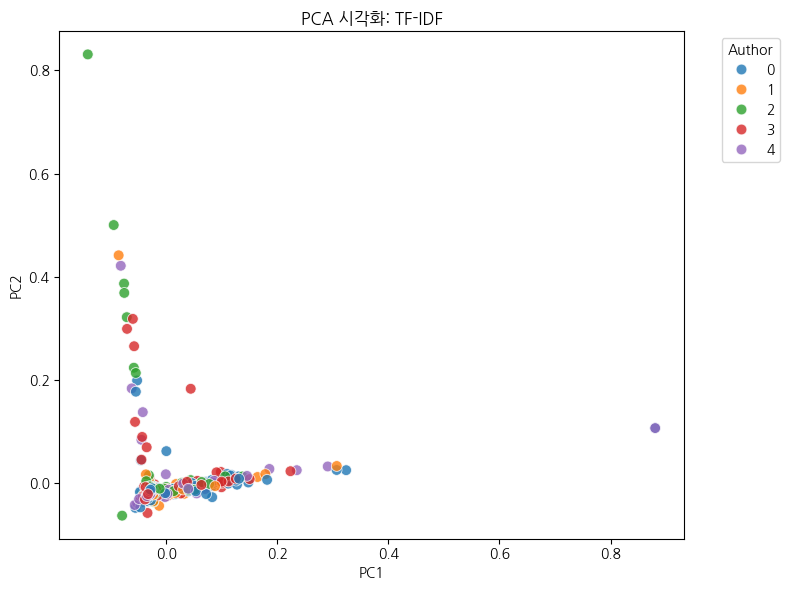

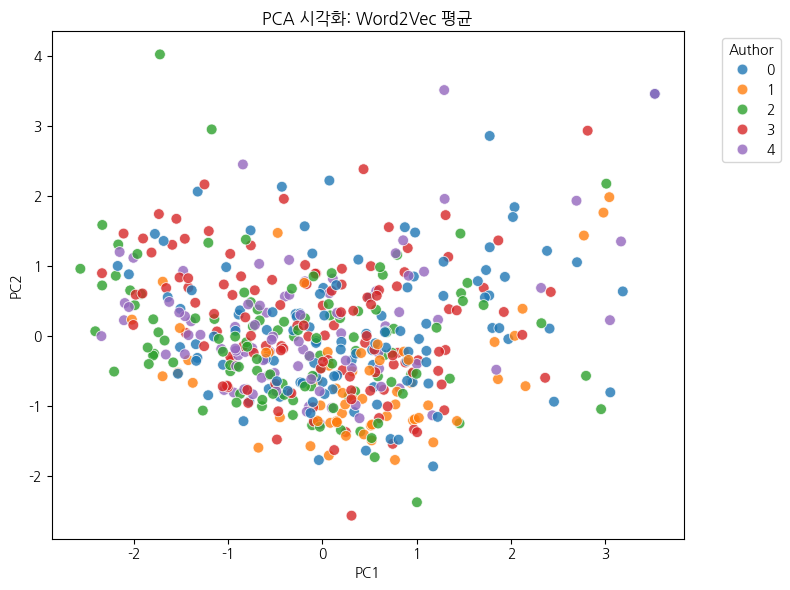

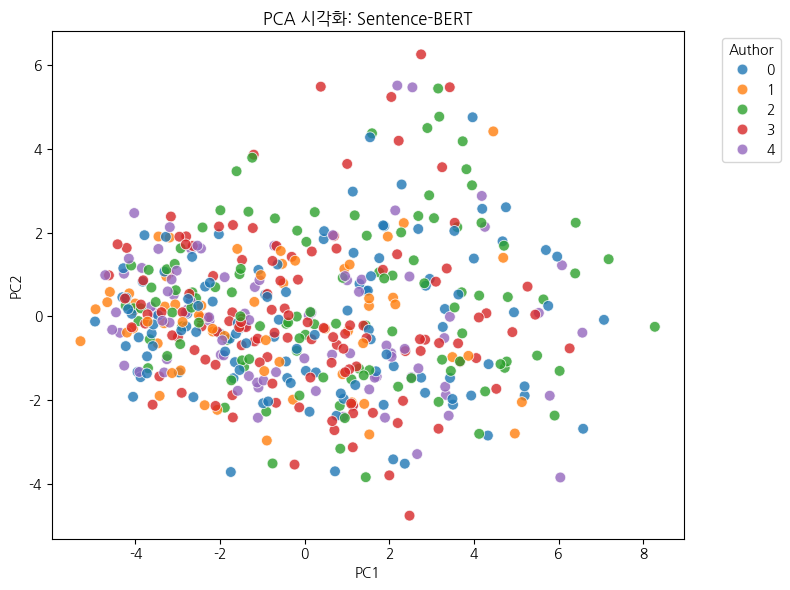

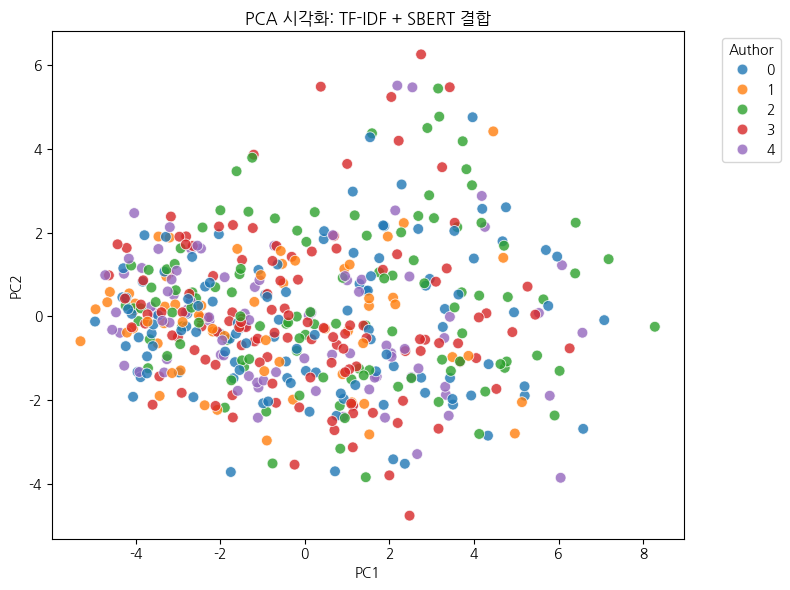

In [ ]:
# 작가 라벨
authors = train['author']

# TF-IDF (희소 행렬이므로 .toarray() 처리됨)
visualize_pca(train_tfidf, authors, "TF-IDF")

# Word2Vec 또는 FastText 평균 벡터
visualize_pca(X_train_vec, authors, "Word2Vec 평균")

# SBERT 벡터
visualize_pca(X_train_sbert, authors, "Sentence-BERT")

# TF-IDF + SBERT 결합 벡터
visualize_pca(X_train_combined, authors, "TF-IDF + SBERT 결합")



---



#**5. Vectorization Optimization**

**실험 조합**

* Data
  * Preprocessed Text Data + Vectorization
  * Meta Feature만
  * 위 두 feature 모두 활용

* Vectorization
  * TF-IDF
  * Word2Vec
  * SBERT
  * TF-IDF + SBERT

* Classifier
  * XGB
  * Multinomial Naive Bayes

## **TF-IDF**

In [ ]:
# pipeline을 통해 tfidf 및 모델의 파라미터를 튜닝하는 코드.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer()),
    ('xgb_clf', XGBClassifier(random_state = 42))])

params = {'tfidf_vect__ngram_range': [(1, 2), (1, 3)],
          'tfidf_vect__min_df' : [0.01, 0.05, 0.1],
          'tfidf_vect__max_df' : [0.9, 0.95, 0.99],
          'tfidf_vect__smooth_idf' : [True],
          'tfidf_vect__sublinear_tf' : [True],
          'tfidf_vect__norm' : ['l2', 'l1']
}

X = train_texts['text']
y = train_texts['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_cv_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='neg_log_loss', verbose=2)
grid_cv_pipe.fit(X_train, y_train)

print(grid_cv_pipe.best_params_, grid_cv_pipe.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END tfidf_vect__max_df=0.9, tfidf_vect__min_df=0.01, tfidf_vect__ngram_range=(1, 2), tfidf_vect__norm=l2, tfidf_vect__smooth_idf=True, tfidf_vect__sublinear_tf=True; total time=  40.6s
[CV] END tfidf_vect__max_df=0.9, tfidf_vect__min_df=0.01, tfidf_vect__ngram_range=(1, 2), tfidf_vect__norm=l2, tfidf_vect__smooth_idf=True, tfidf_vect__sublinear_tf=True; total time=  38.2s
[CV] END tfidf_vect__max_df=0.9, tfidf_vect__min_df=0.01, tfidf_vect__ngram_range=(1, 2), tfidf_vect__norm=l2, tfidf_vect__smooth_idf=True, tfidf_vect__sublinear_tf=True; total time=  39.3s
[CV] END tfidf_vect__max_df=0.9, tfidf_vect__min_df=0.01, tfidf_vect__ngram_range=(1, 2), tfidf_vect__norm=l1, tfidf_vect__smooth_idf=True, tfidf_vect__sublinear_tf=True; total time=  39.5s
[CV] END tfidf_vect__max_df=0.9, tfidf_vect__min_df=0.01, tfidf_vect__ngram_range=(1, 2), tfidf_vect__norm=l1, tfidf_vect__smooth_idf=True, tfidf_vect__sublinear_tf=True; total t

In [ ]:
pred = grid_cv_pipe.predict_proba(X_test)

print('Pipeline을 통한 XGB의 Log Loss는 {0:.3f}'.format(log_loss(y_test, pred)))

Pipeline을 통한 XGB의 Log Loss는 1.182


In [ ]:
results_df = pd.DataFrame(grid_cv_pipe.cv_results_)
results_df[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_test_score,std_test_score
0,"{'tfidf_vect__max_df': 0.9, 'tfidf_vect__min_d...",-1.180559,0.008272
2,"{'tfidf_vect__max_df': 0.9, 'tfidf_vect__min_d...",-1.180559,0.008272
12,"{'tfidf_vect__max_df': 0.95, 'tfidf_vect__min_...",-1.180559,0.008272
14,"{'tfidf_vect__max_df': 0.95, 'tfidf_vect__min_...",-1.180559,0.008272
24,"{'tfidf_vect__max_df': 0.99, 'tfidf_vect__min_...",-1.180559,0.008272
26,"{'tfidf_vect__max_df': 0.99, 'tfidf_vect__min_...",-1.180559,0.008272
3,"{'tfidf_vect__max_df': 0.9, 'tfidf_vect__min_d...",-1.181119,0.007578
1,"{'tfidf_vect__max_df': 0.9, 'tfidf_vect__min_d...",-1.181119,0.007578
25,"{'tfidf_vect__max_df': 0.99, 'tfidf_vect__min_...",-1.181119,0.007578
27,"{'tfidf_vect__max_df': 0.99, 'tfidf_vect__min_...",-1.181119,0.007578


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer with Best Parameters
tfidf_vect = TfidfVectorizer(max_df=0.9, min_df=0.01, ngram_range=(1,2), norm='l1', smooth_idf=True, sublinear_tf=True)

# TF-IDF 학습 및 변환
train_tfidf = tfidf_vect.fit_transform(train_texts['text'])
test_tfidf = tfidf_vect.transform(test_texts['text'])

# TF-IDF 변환 결과 출력
print(f"훈련 데이터 TF-IDF 행렬 크기: {train_tfidf.shape}")
print(f"테스트 데이터 TF-IDF 행렬 크기: {test_tfidf.shape}")

훈련 데이터 TF-IDF 행렬 크기: (54879, 307)
테스트 데이터 TF-IDF 행렬 크기: (19617, 307)


In [ ]:
train_features = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/전처리된 데이터/train_features.csv')
test_features = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/전처리된 데이터/test_features.csv')

In [ ]:
train_features.head()

,index,text,author,char_words,num_words,ave_len,long_rate,punc_rate,unique_rate,stop_rate,...,modi_rate,tense_ratio,num_question,num_exclamation,num_comma,num_period,num_colon,num_semicolon,ngram,compound
0,0,"He was almost choking. There was so much, so m...",3,240,46,5.217391,0.130435,0.033333,0.847826,0.478261,...,0.108696,8.0,0,0,4,3,0,1,0.0,0.3064
1,1,"“Your sister asked for it, I suppose?”",2,38,7,5.428571,0.142857,0.052632,1.000000,0.142857,...,0.000000,1.0,1,0,1,0,0,0,0.0,0.0000
2,2,"She was engaged one day as she walked, in per...",1,320,57,5.614035,0.263158,0.028125,0.877193,0.456140,...,0.140351,6.0,0,0,6,2,1,0,0.0,0.7351
3,3,"The captain was in the porch, keeping himself ...",4,319,58,5.500000,0.206897,0.056426,0.844828,0.413793,...,0.034483,1.0,0,0,9,6,0,2,0.0,0.6908
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,228,39,5.846154,0.153846,0.057018,0.923077,0.410256,...,0.051282,0.0,0,2,4,6,0,1,0.0,0.1984


In [ ]:
from sklearn.preprocessing import StandardScaler

train_meta = train_features.copy()
train_meta = train_meta.drop(['index', 'text', 'author'], axis=1)

test_meta = test_features.copy()
test_meta = test_meta.drop(['index', 'text'], axis=1)

scaler = StandardScaler()
train_meta = scaler.fit_transform(train_meta)
test_meta = scaler.transform(test_meta)

In [ ]:
train_y = train_features['author']

In [ ]:
from scipy.sparse import hstack, csr_matrix
train_X = csr_matrix(train_meta)
train_X = hstack([train_tfidf, train_X])

test_X = csr_matrix(test_meta)
test_X = hstack([test_tfidf, test_X])

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
xgb_clf = XGBClassifier(random_state = 42)
xgb_clf.fit(X_train, y_train)
pred = xgb_clf.predict_proba(X_test)
print('TfIdf+메타데이터 XGB의 Log Loss는 {0:.3f}'.format(log_loss(y_test, pred)))

TfIdf+메타데이터 XGB의 Log Loss는 1.036


**submission**

tfidf(public: 0.9927090689 private:0.9966116228)


tfidf+meta(public: 0.8068832132 private: 0.8079454684	)


In [ ]:
xgb_clf.fit(train_tfidf, train_y)

tfidf_pred = xgb_clf.predict_proba(test_tfidf)

submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = tfidf_pred
submission.to_csv('submission_tfidf.csv', index=False)

In [ ]:
xgb_clf.fit(train_X, train_y)

tfidf_meta_pred = xgb_clf.predict_proba(test_X)

submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = tfidf_meta_pred
submission.to_csv('submission_tfidf_meta.csv', index=False)

## **Word2Vec**

1. preprocessed data + vectorization

* public 점수: 1.0031029883
* private점수: 1.0131249173

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

# target
y = train['author']

# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train_vec, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(43903, 100) (10976, 100) (43903,) (10976,)


In [ ]:
# Validation 데이터로 평가
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# 예측 확률 계산
y_val_pred_prob = xgb.predict_proba(X_val)

# log_loss 계산
log_loss = log_loss(y_val, y_val_pred_prob)
log_loss

1.191361811637653

In [ ]:
# Submission
xgb = XGBClassifier()
xgb.fit(X_train_vec, y)
pred_proba = xgb.predict_proba(X_test_vec)

submission = sample_submission.copy()
submission[['0','1','2','3','4']] = pred_proba
submission.head()

submission.to_csv('submission_w2v_prep_xgb.csv', index=False, encoding = 'utf-8')

2. Meta Feature만
* public 점수: 1.1830482426
* private 점수: 1.1908141285

In [ ]:
# Meta Feature 불러오기
X_train_features = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/전처리 된 데이터/train_features.csv')
X_test_features = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/전처리 된 데이터/test_features.csv')

In [ ]:
X_train_features.columns

Index(['Unnamed: 0', 'text', 'author', 'char_words', 'num_words', 'ave_len',
       'long_rate', 'punc_rate', 'unique_rate', 'stop_rate', 'noun_rate',
       'verb_rate', 'adj_rate', 'adv_rate', 'modi_rate', 'tense_ratio',
       'num_question', 'num_exclamation', 'num_comma', 'num_period',
       'num_colon', 'num_semicolon', 'ngram', 'compound'],
      dtype='object')

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from scipy.sparse import hstack

X_train_features = X_train_features.drop(['Unnamed: 0', 'text', 'author'],axis = 1)

# target
y = train['author']

# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train_features, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(43903, 21) (10976, 21) (43903,) (10976,)


In [ ]:
# Validation 데이터로 평가
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# 예측 확률 계산
y_val_pred_prob = xgb.predict_proba(X_val)

# log_loss 계산
log_loss = log_loss(y_val, y_val_pred_prob)
log_loss

1.2994617337122472

In [ ]:
X_test_features.columns

Index(['Unnamed: 0', 'text', 'char_words', 'num_words', 'ave_len', 'long_rate',
       'punc_rate', 'unique_rate', 'stop_rate', 'noun_rate', 'verb_rate',
       'adj_rate', 'adv_rate', 'modi_rate', 'tense_ratio', 'num_question',
       'num_exclamation', 'num_comma', 'num_period', 'num_colon',
       'num_semicolon', 'ngram', 'compound'],
      dtype='object')

In [ ]:
X_test_features = X_test_features.drop(['Unnamed: 0', 'text'],axis = 1)

In [ ]:
# Submission
xgb = XGBClassifier()
xgb.fit(X_train_features, y)
pred_proba = xgb.predict_proba(X_test_features)

submission = sample_submission.copy()
submission[['0','1','2','3','4']] = pred_proba
submission.head()

submission.to_csv('submission_w2v_meta_xgb.csv', index=False, encoding = 'utf-8')

3. Text + Meta features
* public 점수: 0.7902835259
* private 점수: 0.7912582812

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# target
y = train['author']

# 텍스트 데이터와 이외 데이터 결합
X_train_combined = np.concatenate((X_train_vec, X_train_features), axis=1)

# train test split
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(43903, 121) (10976, 121) (43903,) (10976,)


In [ ]:
# Validation 데이터로 평가
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# 예측 확률 계산
y_val_pred_prob = xgb.predict_proba(X_val)

# log_loss 계산
log_loss = log_loss(y_val, y_val_pred_prob)
log_loss

1.033304613082914

In [ ]:
# 텍스트 데이터와 이외 데이터 결합
X_test_combined = np.concatenate((X_test_vec, X_test_features), axis=1)

In [ ]:
# Submission
xgb = XGBClassifier()
xgb.fit(X_train_combined, y)
pred_proba = xgb.predict_proba(X_test_combined)

submission = sample_submission.copy()
submission[['0','1','2','3','4']] = pred_proba
submission.head()

submission.to_csv('submission_w2v_full_xgb.csv', index=False, encoding = 'utf-8')

## **SBERT**

1. Preprocessed Text Data + vectorization (log loss: 1.359624)

* public 점수: 1.2937075932
* private점수: 1.3054374028

In [ ]:
# 데이터 불러오기
X_train_sbert = np.load('sbert_preprocessed_train.npy')
X_test_sbert = np.load('sbert_preprocessed_test.npy')

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# target
y = train['author']

# train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train_sbert, y, test_size=0.2, random_state=56)

# 모델 학습 및 평가
xgb = XGBClassifier(random_state=56)
xgb.fit(X_train, y_train)

y_val_pred_prob = xgb.predict_proba(X_val)
val_loss = log_loss(y_val, y_val_pred_prob)
print(f"Validation Log Loss: {val_loss:.6f}")

Validation Log Loss: 1.359624


In [ ]:
# 최종 학습 및 제출
xgb = XGBClassifier(random_state=56)
xgb.fit(X_train_sbert, y)
pred_proba = xgb.predict_proba(X_test_sbert)

submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = pred_proba
submission.to_csv('submission_sbert_only.csv', index=False)

2. Meta Feature만 사용 (log loss: 1.299456)

* public 점수: 1.1827039849
* private점수: 1.1847845791

In [ ]:
# 메타 피처 불러오기
X_train_meta = pd.read_csv('train_features.csv')
X_test_meta = pd.read_csv('test_features.csv')

In [ ]:
X_train_meta.columns

Index(['index', 'text', 'author', 'char_words', 'num_words', 'ave_len',
       'long_rate', 'punc_rate', 'unique_rate', 'stop_rate', 'noun_rate',
       'verb_rate', 'adj_rate', 'adv_rate', 'ner_rate', 'modi_rate',
       'tense_ratio', 'num_question', 'num_exclamation', 'num_comma',
       'num_period', 'num_colon', 'num_semicolon', 'ngram', 'compound'],
      dtype='object')

In [ ]:
# 불필요한 컬럼 제거
X_train_meta = X_train_meta.drop(['index', 'text', 'author'], axis=1)
X_test_meta = X_test_meta.drop(['index', 'text'], axis=1)

# target
y = train['author']

# train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train_meta, y, test_size=0.2, random_state=56)

# 모델 학습 및 평가
xgb = XGBClassifier(random_state=56)
xgb.fit(X_train, y_train)

y_val_pred_prob = xgb.predict_proba(X_val)
val_loss = log_loss(y_val, y_val_pred_prob)
print(f"Validation Log Loss: {val_loss:.6f}")

Validation Log Loss: 1.299456


In [ ]:
# 최종 학습 및 제출
xgb = XGBClassifier(random_state=56)
xgb.fit(X_train_meta, y)
pred_proba = xgb.predict_proba(X_test_meta)

submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = pred_proba
submission.to_csv('submission_sbert_meta_only.csv', index=False)

3. Text + Meta Feature 모두 활용 (log loss: 1.193539)

* public 점수: 1.0285711903
* private점수: 1.0542943025

In [ ]:
# SBERT + Meta Feature 결합
X_train_combined = np.concatenate((X_train_sbert, X_train_meta), axis=1)
X_test_combined = np.concatenate((X_test_sbert, X_test_meta), axis=1)

# train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train_combined, y, test_size=0.2, random_state=56)

# 모델 학습 및 평가
xgb = XGBClassifier(random_state=56)
xgb.fit(X_train, y_train)

y_val_pred_prob = xgb.predict_proba(X_val)
val_loss = log_loss(y_val, y_val_pred_prob)
print(f"Validation Log Loss: {val_loss:.6f}")

Validation Log Loss: 1.193539


In [ ]:
# 최종 학습 및 제출
xgb = XGBClassifier(random_state=56)
xgb.fit(X_train_combined, y)
pred_proba = xgb.predict_proba(X_test_combined)

submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = pred_proba
submission.to_csv('submission_sbert_full.csv', index=False)

## **TF-IDF + SBERT**

1. Preprocessed Text Data + vectorization (log loss: )

* public 점수 : 1.4661079427
* private점수 : 1.4687574897

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

In [ ]:
# 1. 텍스트 토큰을 문자열로 결합
train_tokens['text_joined'] = train_tokens['text'].apply(lambda x: ' '.join(x))
test_tokens['text_joined'] = test_tokens['text'].apply(lambda x: ' '.join(x))

In [ ]:
# 2. TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.5
)
train_tfidf = tfidf_vectorizer.fit_transform(train_tokens['text_joined'])  # sparse matrix
test_tfidf = tfidf_vectorizer.transform(test_tokens['text_joined'])        # sparse matrix

In [ ]:
# 3. SBERT 벡터화
sbert_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
train_sbert = sbert_model.encode(train['text'].tolist(), show_progress_bar=True, convert_to_numpy=True)
test_sbert = sbert_model.encode(test['text'].tolist(), show_progress_bar=True, convert_to_numpy=True)

In [ ]:
# 4. TF-IDF to array (sparse → dense)
train_tfidf_array = train_tfidf.toarray()
test_tfidf_array = test_tfidf.toarray()

In [ ]:
# 5. 결합 (TF-IDF + SBERT)
X_train_tisbert = np.concatenate([train_tfidf_array, train_sbert], axis=1)
X_test_tisbert = np.concatenate([test_tfidf_array, test_sbert], axis=1)

# 6. 확인
print(f"최종 훈련 크기 : {X_train_tisbert.shape}")
print(f"최종 테스트 크기 : {X_test_tisbert.shape}")

In [ ]:
# 최종 학습 및 제출
xgb = XGBClassifier()
xgb.fit(X_train_tisbert, y)
pred_proba = xgb.predict_proba(X_test_tisbert)

submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = pred_proba
submission.to_csv('submission_tisbert.csv', index=False)

2. Meta Feature

In [ ]:
# 메타 피처 불러오기
train_features = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/전처리 된 데이터/train_features.csv')
test_features = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/프로젝트 2/data/전처리 된 데이터/tesr_features.csv')

In [ ]:
train_features.columns

Index(['index', 'text', 'author', 'char_words', 'num_words', 'ave_len',
       'long_rate', 'punc_rate', 'unique_rate', 'stop_rate', 'noun_rate',
       'verb_rate', 'adj_rate', 'adv_rate', 'ner_rate', 'modi_rate',
       'tense_ratio', 'num_question', 'num_exclamation', 'num_comma',
       'num_period', 'num_colon', 'num_semicolon', 'ngram', 'compound'],
      dtype='object')

In [ ]:
# 불필요한 컬럼 제거
train_features = train_features.drop(['index', 'text', 'author'], axis=1)
test_features = train_features.drop(['index', 'text'], axis=1)

# target
y = train['author']

Validation Log Loss: 1.295906


3. Text + Meta Feature 모두 활용 (log loss: )

* public 점수:
* private점수:

In [ ]:
# TF-IDF & SBERT + Meta Feature 결합
X_train_combined = np.concatenate((X_train_tisbert, X_train_meta), axis=1)
X_test_combined = np.concatenate((X_test_tisbert, X_test_meta), axis=1)

# train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train_combined, y, test_size=0.2, random_state=56)

# 모델 학습 및 평가
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_val_pred_prob = xgb.predict_proba(X_val)
val_loss = log_loss(y_val, y_val_pred_prob)
print(f"Validation Log Loss: {val_loss:.6f}")

Validation Log Loss: 1.176853


In [ ]:
# 최종 학습 및 제출
xgb = XGBClassifier()
xgb.fit(X_train_combined, y)
pred_proba = xgb.predict_proba(X_test_combined)

submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = pred_proba
submission.to_csv('submission_sbert_full.csv', index=False)



---



# 6. Modeling

### Optuna를 이용한 XGBoost GridSearchCV

4시간 30분 돌린 것 기준

public: 0.7512244305
private: 0.750679864

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score

def objective(trial):
    param = {
        "objective": "multi:softprob",
        "num_class": 5,  # 클래스 개수
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "use_label_encoder": False,
        "eval_metric": "mlogloss",
        "random_state": 56
    }

    model = xgb.XGBClassifier(**param)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    return acc  # 높을수록 좋으니 maximize

# Optuna 탐색 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best accuracy:", study.best_value)
print("Best hyperparameters:", study.best_trial.params)


[I 2025-05-16 03:35:15,789] A new study created in memory with name: no-name-0177fbb1-93a9-4f41-9e5d-85caec3067a1
[I 2025-05-16 03:37:49,900] Trial 0 finished with value: 0.5360787172011662 and parameters: {'learning_rate': 0.05946749832355122, 'max_depth': 8, 'n_estimators': 154}. Best is trial 0 with value: 0.5360787172011662.
[I 2025-05-16 03:38:47,723] Trial 1 finished with value: 0.5154883381924198 and parameters: {'learning_rate': 0.018107477216931497, 'max_depth': 4, 'n_estimators': 332}. Best is trial 0 with value: 0.5360787172011662.
[I 2025-05-16 03:42:36,262] Trial 2 finished with value: 0.5407252186588921 and parameters: {'learning_rate': 0.07250439299673125, 'max_depth': 6, 'n_estimators': 654}. Best is trial 2 with value: 0.5407252186588921.
[I 2025-05-16 03:43:17,726] Trial 3 finished with value: 0.516399416909621 and parameters: {'learning_rate': 0.029936766031609115, 'max_depth': 3, 'n_estimators': 332}. Best is trial 2 with value: 0.5407252186588921.
[I 2025-05-16 03:

Best accuracy: 0.5438228862973761
Best hyperparameters: {'learning_rate': 0.104379572877097, 'max_depth': 6, 'n_estimators': 911}


In [ ]:
final_model = xgb.XGBClassifier(**study.best_trial.params)
final_model.fit(X_train_combined, y)

pred_proba = final_model.predict_proba(X_test_combined)

submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = pred_proba
submission.to_csv('submission_final.csv', index=False)

### GridSearchCV를 이용한 XGBoost 하이퍼파라미터 튜닝

> 시간 상의 이슈로 제출 후 돌려서 결과 제출하겠습니다...

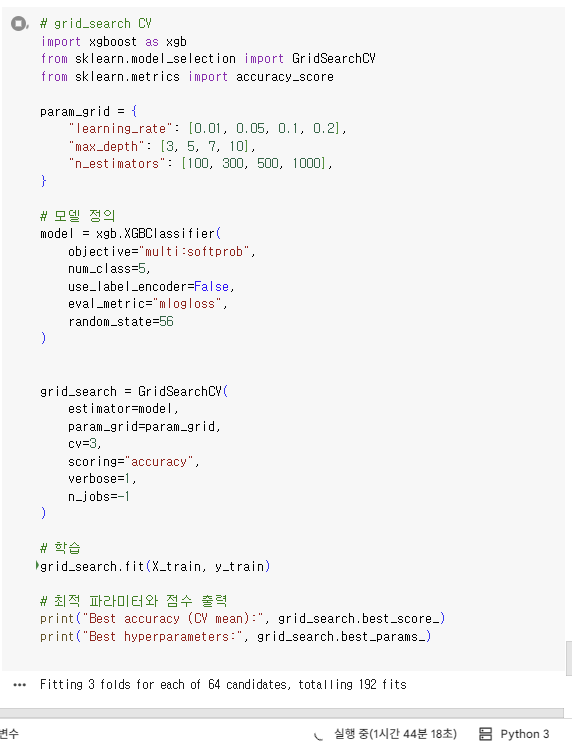

In [ ]:
# grid_search CV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [100, 300, 500, 1000],
}

# 모델 정의
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=56
)


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

# 학습
grid_search.fit(X_train, y_train)

# 최적 파라미터와 점수 출력
print("Best accuracy (CV mean):", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


KeyboardInterrupt: 

In [ ]:
# GridSearchCV에서 찾은 최적 모델 사용
final_model = grid_search.best_estimator_

# 전체 학습 데이터로 재학습 (optuna와 동일하게 X_train_combined 전체 사용)
final_model.fit(X_train_combined, y)

# 테스트 데이터 예측
pred_proba = final_model.predict_proba(X_test_combined)

# 제출 파일 생성
submission = sample_submission.copy()
submission[['0', '1', '2', '3', '4']] = pred_proba
submission.to_csv('submission_final.csv', index=False)

# 7. 결과

<table border="1">
  <tr>
    <th> 모델 </th>
    <th> 데이터 </th>
    <th>Public 점수 </th>
    <th> Private 점수 </th>
  </tr>
  <tr>
    <th rowspan="3">Word2Vec</th>
    <td> <center> preprocessed data + vectorization </td>
    <td>1.0031029883</td>
    <td>1.0131249173</td>
  </tr>
  <tr>
    <td> <center> Meta Feature만 </td>
    <td>1.1830482426</td>
    <td>1.1908141285</td>
  </tr>
  <tr>
    <td> <center> Text + Meta features</td>
    <td> 0.7902835259</td>
    <td>0.7912582812</td>
  </tr>
  <tr>
    <th rowspan="3">SBERT</th>
    <td> <center> preprocessed data + vectorization </td>
    <td> 1.2937075932</td>
    <td>1.3054374028</td>
  </tr>
  <tr>
    <td> <center> Meta Feature만 </td>
    <td>1.1827039849</td>
    <td>1.1847845791</td>
  </tr>
  <tr>
    <td> <center> Text + Meta features</td>
    <td>1.0285711903</td>
    <td>1.0542943025</td>
  </tr>
  <tr>
    <th rowspan="3">TF-IDF + SBERT</th>
    <td> <center> preprocessed data + vectorization </th>public 점수 :  
    <td> 1.4661079427</td>
    <td> 1.4687574897</td>
  </tr>
  <tr>
    <td> <center> Meta Feature만 </td>
    <td>public 점수</td>
    <td>private 점수</td>
  </tr>
  <tr>
    <td> <center> Text + Meta features</td>
    <td>public 점수</td>
    <td>private 점수</td>
  </tr>
  </table>